In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression, QuantileRegressor
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm
import seaborn as sns
import scienceplots
from scipy import stats


In [ ]:

df = pd.read_csv('price_reduction_models.csv')
print(df.columns)
#convert price to float
# df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)

# Function to find and analyze duplicate rows
def find_duplicates(df, subset=None, save_to_csv=False, output_file='duplicates.csv'):
    """
    Find duplicate rows in a DataFrame based on all columns (or specified subset).
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame to check for duplicates
    subset : list, optional
        List of column names to check for duplicates. If None, uses all columns.
    save_to_csv : bool
        If True, save duplicate rows to a CSV file
    output_file : str
        Name of output CSV file if save_to_csv is True
    
    Returns:
    --------
    pd.DataFrame : DataFrame containing all duplicate rows
    """
    # Find all duplicate rows (keep=False marks all occurrences)
    if subset is None:
        duplicates = df[df.duplicated(keep=False)]
    else:
        duplicates = df[df.duplicated(subset=subset, keep=False)]
    
    print(f"Total rows in dataset: {len(df)}")
    print(f"Duplicate rows found: {len(duplicates)}")
    print(f"Unique duplicate groups: {len(duplicates.drop_duplicates())}")
    
    if len(duplicates) > 0:
        print(f"\nFirst duplicate rows:")
        print(duplicates.head(20))
        
        if save_to_csv:
            duplicates.to_csv(output_file, index=False)
            print(f"\nDuplicate rows saved to: {output_file}")
    else:
        print("\nNo duplicate rows found!")
    
    return duplicates

# Example usage:
# duplicates = find_duplicates(df)
# duplicates = find_duplicates(df, subset=['Model', 'Release Date'])  # Check specific columns
# duplicates = find_duplicates(df, save_to_csv=True, output_file='my_duplicates.csv')

#print the first 5 rows of the datafr

Index(['Model', 'Creator', 'License', 'Context\r\n Window',
       'Artificial Analysis\r\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\r\n USD/1M Tokens', 'Median\r\n Tokens/s', 'P5\r\n Tokens/s',
       'P25\r\n Tokens/s', 'P75\r\n Tokens/s', 'P95\r\n Tokens/s',
       'Median\r\n First Chunk (s)', 'First Answer\r\n Token (s)',
       'P5\r\n First Chunk (s)', 'P25\r\n First Chunk (s)',
       'P75\r\n First Chunk (s)', 'P95\r\n First Chunk (s)',
       'Total\r\n Response (s)', 'Reasoning\r\n Time (s)', 'Reasoning_TF',
       'Further\r\n Analysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Latency', 'token/s',

Index(['Model', 'Model Slug', 'Creator', 'License', 'Context\r\n Window',
       'Access Date on AA', 'Artificial Analysis\r\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       ...
       '6/1/2025 input price', '6/1/2025 output price', '7/1/2025 input price',
       '7/1/2025 output price', '8/1/2025 input price',
       '8/1/2025 output price', '9/1/2025 input price',
       '9/1/2025 output price', '10/1/2025 input price',
       '10/1/2025 output price'],
      dtype='object', length=131)


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_70186/2630777878.py:199: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


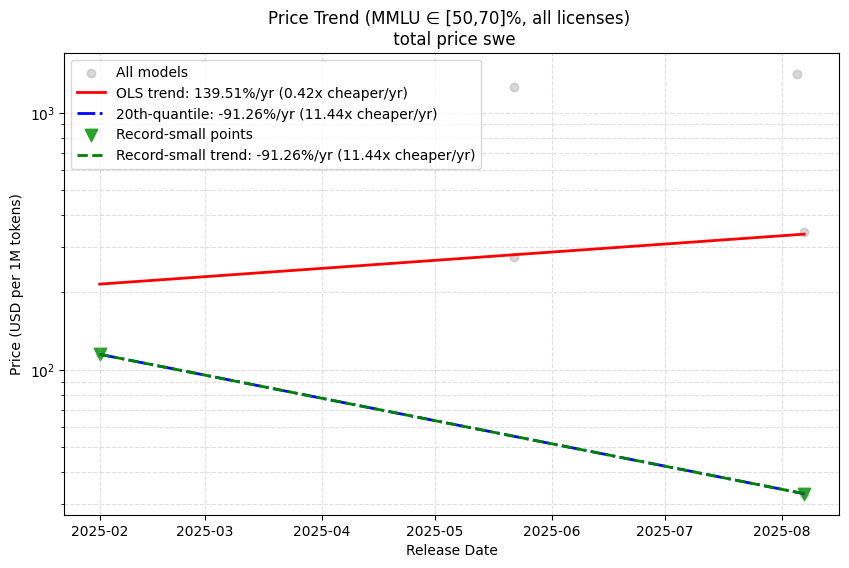

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime
from scipy import stats

def plot_price_trend_by_mmlu(
    min_mmlu, 
    max_mmlu, 
    open_license_only=False, 
    quantile=0.2, 
    price_col='Output Price\nUSD/1M Tokens',
    mmlu_col='MMLU-Pro (Reasoning & Knowledge)', 
    show_model_names=False, 
    show_confidence_interval=False,
    df=None
):
    """
    Plot price‐per‐1M-token trends for models with MMLU in [min_mmlu, max_mmlu].
    If open_license_only=True, only keep rows where `license_col` contains 'open' (case‐insensitive).
    You can pass a DataFrame as `df`. If not provided, uses global `df`.
    Assumes DataFrame has columns:
      - 'Release Date' (datetime64)
      - mmlu_col (e.g. "75%")
      - price_col (e.g. "$0.50")
      - license_col (e.g. 'License')
    
    Parameters:
      min_mmlu: Minimum MMLU score to include
      max_mmlu: Maximum MMLU score to include
      open_license_only: If True, only include models with open licenses
      quantile: Quantile level for the quantile regression (default: 0.5 for median)
      price_col: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
      mmlu_col: Column name for MMLU data
      show_model_names: If True, displays model names next to record-small points
      show_confidence_interval: If True, shows 90% confidence interval for record-small trend
      df: DataFrame to use (optional; if None, uses global `df`)
    """
    # --- column names ---
    license_col = 'License'   # ← adjust if your CSV uses a different header

    # 1) Work on a copy
    if df is None:
        df_work = globals()['df'].copy()
    else:
        df_work = df.copy()

    # 2) Convert MMLU "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%','',regex=False)
                         .astype(float)
    )

    # 3) Convert price "$X,XXX" → float
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]','',regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

    # 4) Optionally filter to open‐license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 5) Filter to MMLU range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 6) Drop missing Release Date or price, remove non‐positive prices
    df_sub = df_sub.dropna(subset=['Release Date', price_col])
    df_sub = df_sub[df_sub[price_col] > 0]

    # 7) Sort & compute ordinal date
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

    # 8) Prepare regressions on log10(price)
    X     = df_sub['Date_Ordinal'].values.reshape(-1,1)
    y_log = np.log10(df_sub[price_col].values)

    # overall OLS
    ols = LinearRegression().fit(X, y_log)
    # quantile regression with specified quantile
    qr  = QuantileRegressor(quantile=quantile, alpha=0.0).fit(X, y_log)

    # 9) Build daily grid for predictions
    min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range = np.arange(min_ord, max_ord + 1)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]

    y_ols_log = ols.predict(x_range.reshape(-1,1))
    y_qr_log  = qr.predict(x_range.reshape(-1,1))

    # 10) Compute annualized % growth and price decrease factor
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_factor_ols = 1 / (10**ols.coef_[0])**365
    
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100
    annual_factor_qr = 1 / (10**qr.coef_[0])**365

    # 11) "Record‐small" = running minima of price
    df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # OLS on those
    X_rec         = record_small['Date_Ordinal'].values.reshape(-1,1)
    y_rec_log     = np.log10(record_small[price_col].values)
    rec_ols       = LinearRegression().fit(X_rec, y_rec_log)
    y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
    annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
    annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365
    
    # Calculate confidence interval for record-small trend if requested
    ci_text = ""
    if show_confidence_interval and len(X_rec) > 2:
        # Get prediction interval for the coefficient
        n = len(X_rec)
        mean_x = np.mean(X_rec)
        t_val = stats.t.ppf(0.95, n-2)  # 90% CI (two-tailed)
        
        # Standard error calculation
        sum_squared_errors = np.sum((y_rec_log - rec_ols.predict(X_rec))**2)
        sum_squared_x_diff = np.sum((X_rec.flatten() - mean_x)**2)
        std_err = np.sqrt(sum_squared_errors / (n-2) / sum_squared_x_diff)
        
        # Confidence interval for slope
        ci_lower = rec_ols.coef_[0] - t_val * std_err
        ci_upper = rec_ols.coef_[0] + t_val * std_err
        
        # Convert to annual factors
        annual_factor_lower = 1 / (10**ci_lower)**365
        annual_factor_upper = 1 / (10**ci_upper)**365
        
        ci_text = f" (90% CI: {annual_factor_lower:.2f}x-{annual_factor_upper:.2f}x)"

    # 12) Plot
    plt.figure(figsize=(10,6))
    # all
    plt.scatter(df_sub['Release Date'], df_sub[price_col],
                color='gray', alpha=0.3, label='All models')
    # OLS trend
    plt.plot(x_dates, 10**y_ols_log, 'r-', lw=2,
             label=f'OLS trend: {annual_pct_ols:.2f}%/yr ({annual_factor_ols:.2f}x cheaper/yr)')
    # specified quantile
    plt.plot(x_dates, 10**y_qr_log, 'b-.', lw=2,
             label=f'{quantile*100:.0f}th-quantile: {annual_pct_qr:.2f}%/yr ({annual_factor_qr:.2f}x cheaper/yr)')
    # record-small points
    plt.scatter(record_small['Release Date'], record_small[price_col],
                color='tab:green', s=80, marker='v',
                label='Record-small points')
    # record-small trend
    plt.plot(x_dates, 10**y_rec_log_pred, 'g--', lw=2,
             label=f'Record-small trend: {annual_pct_rec:.2f}%/yr ({annual_factor_rec:.2f}x cheaper/yr{ci_text})')
    
    # Add confidence interval bands if requested
    if show_confidence_interval and len(X_rec) > 2:
        # Calculate prediction bands
        y_lower = ci_lower * (x_range - min_ord) + rec_ols.intercept_
        y_upper = ci_upper * (x_range - min_ord) + rec_ols.intercept_
        
        plt.fill_between(x_dates, 10**y_lower, 10**y_upper, 
                         color='green', alpha=0.1, 
                         label='90% CI for record-small trend')
    
    # Add model names if requested
    if show_model_names:
        for idx, row in record_small.iterrows():
            plt.annotate(row['Model'], 
                         (row['Release Date'], row[price_col]),
                         xytext=(5, 5), 
                         textcoords='offset points',
                         fontsize=8)

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Price (USD per 1M tokens)')
    lic_label = 'open‐license only' if open_license_only else 'all licenses'
    plt.title(f'Price Trend (MMLU ∈ [{min_mmlu},{max_mmlu}]%, {lic_label}) \n {price_col}')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()




df = pd.read_csv('inference_data_new_large.csv')
print(df.columns)
#convert price to float
# df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])

plot_price_trend_by_mmlu(50,70,  open_license_only=False, quantile=0.2, price_col="total price swe", mmlu_col='epoch_swe', show_confidence_interval=True, df=df)





# plot_price_trend_by_mmlu(10, 30, open_license_only=True, quantile=0.2, price_col="Lowest Blended Price AA", show_model_names=True,show_confidence_interval=True, df=df)

# Example usage:
# plot_price_trend_by_mmlu(50, 70, open_license_only=True, quantile=0.2, show_confidence_interval=True, df=df)

In [10]:
# # import seaborn as sns
# # import matplotlib.pyplot as plt
# # from matplotlib.dates import DateFormatter
# # import scienceplots
# # from datetime import datetime
# # import numpy as np
# # import pandas as pd
# # from sklearn.linear_model import LinearRegression
# # from scipy import stats


# # get predictions at highly skewed
# #R^2 regression


# df = pd.read_csv('price_reduction_models.csv')
# print(df.columns)
# #convert price to float
# # df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# # df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# # df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


# #convert release date to datetime where release date is not nan
# df['Release Date'] = pd.to_datetime(df['Release Date'])



# # # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
# df['Active Parameters'] = np.where(
#     df['Known Active Parameters'].notna(),
#     df['Known Active Parameters'],
#     df['Parameters']
# )
# def plot_combined_record_small_trends(open_license_only=False, price_col='Lowest Blended Price AA', show_model_names=False, min_date=datetime(2023, 1, 1), confidence_interval=True, include_chinese=None, benchmark_col='MMLU-Pro (Reasoning & Knowledge)', mmlu_ranges=[(30, 50), (50, 70), (70, 90)], include_reasoning_models=True):
#     """
#     Plot record-small points and their trend lines for specified MMLU ranges 
#     on a single graph with enhanced styling. Includes 90% confidence intervals.
    
#     Parameters:
#       open_license_only: If True, only include models with open licenses
#       price_col: Column name for price data (default: 'Lowest Blended Price AA')
#       show_model_names: If True, displays model names next to record-small points
#       min_date: If provided, only include models released on or after this date (datetime or string)
#                 Default is January 1, 2024
#       confidence_interval: If True, displays 90% confidence intervals for trend lines
#       include_chinese: Filter for Chinese models - if True, only include Chinese models; 
#                       if False, exclude Chinese models; if None, include all models
#       benchmark_col: Column name for the benchmark to use (default: 'MMLU-Pro (Reasoning & Knowledge)')
#       mmlu_ranges: List of tuples defining MMLU score ranges (default: [(30, 50), (50, 70), (70, 90)])
#       include_reasoning_models: If True, include reasoning models; if False, exclude reasoning models (default: True)
#     """
#     # Set up the styling with standard matplotlib font
#     plt.rcParams['font.family'] = 'sans-serif'
    
#     # Create figure with specific dimensions
#     fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    
#     # Set background to white
#     fig.patch.set_facecolor('white')
#     ax.set_facecolor('white')
    
#     # Use provided MMLU ranges with custom palette
#     palette = sns.color_palette("viridis", n_colors=len(mmlu_ranges))
#     markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # Extended list of markers
    
#     # --- column names ---
#     mmlu_col = benchmark_col
#     license_col = 'License'
#     chinese_col = 'Chinese'
#     reasoning_col = 'Reasoning_TF'
    
#     # Store all data for setting axis limits
#     all_dates = []
#     all_prices = []
    
#     for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
#         color = palette[i]
#         marker = markers[i % len(markers)]  # Cycle through markers if we have more ranges than markers
        
#         # 1) Work on a copy
#         df_work = df.copy()

#         # 2) Convert MMLU "XX%" → float
#         df_work[mmlu_col] = (
#             df_work[mmlu_col].astype(str)
#                              .str.replace('%','',regex=False)
#                              .astype(float)
#         )

#         # 3) Convert price "$X,XXX" → float
#         df_work[price_col] = (
#             df_work[price_col].astype(str)
#                              .str.replace('[$,]','',regex=True)
#         )
#         df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

#         # 4) Optionally filter to open‐license only
#         if open_license_only:
#             df_work = df_work[
#                 df_work[license_col].notna() &
#                 df_work[license_col].str.contains('open', case=False, na=False)
#             ]
            
#         # 4b) Filter by date if min_date is provided
#         if min_date is not None:
#             if isinstance(min_date, str):
#                 min_date = pd.to_datetime(min_date)
#             df_work = df_work[df_work['Release Date'] >= min_date]
            
#         # 4c) Filter by Chinese models if specified
#         if include_chinese is not None:
#             if include_chinese:
#                 # Only include Chinese models (where Chinese column is TRUE)
#                 df_work = df_work[df_work[chinese_col] == True]
#             else:
#                 # Exclude Chinese models (where Chinese column is TRUE)
#                 df_work = df_work[(df_work[chinese_col] != True) | (df_work[chinese_col].isna())]
                
#         # 4d) Filter by reasoning models if specified
#         if not include_reasoning_models:
#             # Exclude reasoning models (where Reasoning_TF column is TRUE)
#             df_work = df_work[(df_work[reasoning_col] != True) | (df_work[reasoning_col].isna())]

#         # 5) Filter to MMLU range
#         df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

#         # 6) Drop missing Release Date or price, remove non‐positive prices
#         df_sub = df_sub.dropna(subset=['Release Date', price_col])
#         df_sub = df_sub[df_sub[price_col] > 0]

#         # Skip if no data
#         if len(df_sub) == 0:
#             continue

#         # 7) Sort & compute ordinal date
#         df_sub = df_sub.sort_values('Release Date')
#         df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

#         # 8) "Record‐small" = running minima of price
#         df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
#         record_small = df_sub[df_sub['Is_Record_Small']].copy()
        
#         # Skip if no record small points
#         if len(record_small) == 0:
#             continue

#         # 9) Linear regression on record small points (log scale)
#         X_rec = record_small['Date_Ordinal'].values.reshape(-1,1)
#         y_rec_log = np.log10(record_small[price_col].values)
#         rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        
#         # Calculate R^2 value
#         r_squared = rec_ols.score(X_rec, y_rec_log)
#         print(f"MMLU {min_mmlu}-{max_mmlu}% R² = {r_squared:.3f}")
        
#         # 10) Create prediction line
#         min_ord, max_ord = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
#         x_range = np.arange(min_ord, max_ord + 1)
#         x_dates = [datetime.fromordinal(int(d)) for d in x_range]
#         y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
        
#         # 11) Calculate annual decrease rate
#         annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
#         annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365
        
#         # Calculate 90% confidence intervals for the slope if requested
#         # ci_label = ""
#         n = len(X_rec)
#         if confidence_interval and n > 2:  # Need at least 3 points for confidence interval
#             # Calculate residuals and standard error
#             y_pred = rec_ols.predict(X_rec)
#             residuals = y_rec_log - y_pred
#             mse = np.sum(residuals**2) / (n - 2)
#             se = np.sqrt(mse / np.sum((X_rec - np.mean(X_rec))**2))
            
#             # t-value for 90% confidence interval (two-tailed)
#             t_val = stats.t.ppf(0.95, n - 2)
            
#             # Confidence interval for slope
#             ci_lower = rec_ols.coef_[0] - t_val * se
#             ci_upper = rec_ols.coef_[0] + t_val * se
            
#             # Convert to annual factors
#             annual_factor_lower = 1 / (10**ci_upper)**365  # Note: Upper CI of negative slope gives lower factor
#             annual_factor_upper = 1 / (10**ci_lower)**365  # Note: Lower CI of negative slope gives upper factor
            
#             ci_label = f" (90% CI: {annual_factor_lower:.1f}x-{annual_factor_upper:.1f}x)"
#             # ci_label = ""

#         # 12) Plot record small points with enhanced styling
#         sns.scatterplot(
#             x=record_small['Release Date'], 
#             y=record_small[price_col],
#             color=color, 
#             s=100,  # Slightly larger points
#             marker=marker, 
#             alpha=0.9,
#             edgecolor='white',
#             linewidth=0.5,
#             ax=ax
#         )
        
#         # 13) Plot trend line with enhanced styling
#         # Create a readable benchmark name for the legend
#         benchmark_name = benchmark_col.split(" ")[0]
#         if benchmark_name == 'epoch_gpqa':
#             benchmark_name = 'GPQA-D'
        
#         ax.plot(
#             x_dates, 
#             10**y_rec_log_pred, 
#             color=color, 
#             linestyle='--', 
#             linewidth=2.5,
#             alpha=0.8,
#             label=f'{benchmark_name} {min_mmlu}-{max_mmlu}% trend: ({annual_factor_rec:.1f}x cheaper/yr){ci_label}'
#         )
        
#         # Plot confidence intervals if we have enough data points and confidence_interval is True
#         if confidence_interval and n > 2:
#             y_lower = ci_lower * x_range + rec_ols.intercept_
#             y_upper = ci_upper * x_range + rec_ols.intercept_
            
#             ax.fill_between(
#                 x_dates,
#                 10**y_lower,
#                 10**y_upper,
#                 color=color,
#                 alpha=0.1
#             )
        
#         # 14) Add model names if requested
#         if show_model_names:
#             for idx, row in record_small.iterrows():
#                 ax.annotate(
#                     row['Model'], 
#                     (row['Release Date'], row[price_col]),
#                     xytext=(5, 5), 
#                     textcoords='offset points',
#                     fontsize=9,
#                     color=color,
#                     fontweight='bold',
#                     alpha=0.9
#                 )
        
#         # Store data for axis limits
#         all_dates.extend(record_small['Release Date'].tolist())
#         all_prices.extend(record_small[price_col].tolist())
    
#     # 15) Enhanced formatting
#     ax.set_yscale('log')
#     ax.set_xlabel('Date', fontsize=18, fontweight='bold')
#     ax.set_ylabel('Benchmark Cost GPQA-D (USD)', fontsize=18, fontweight='bold')
    
#     # Format date axis
#     date_formatter = DateFormatter('%b %Y')
#     ax.xaxis.set_major_formatter(date_formatter)
#     plt.xticks(rotation=45)
    
#     # Title with styling
#     lic_label = 'open-license only' if open_license_only else 'all licenses'
#     date_filter = f" (since {min_date.strftime('%b %Y')})" if min_date is not None else ""
#     chinese_filter = " (Chinese models only)" if include_chinese is True else " (non-Chinese models)" if include_chinese is False else ""
#     reasoning_filter = " (non-reasoning models)" if not include_reasoning_models else ""
#     benchmark_name = benchmark_col.split(" ")[0]  # Extract first part of benchmark name for title
#     ax.set_title(f'Lowest Available Price Trends by Epoch GPQA Range ({lic_label}){date_filter}{chinese_filter}{reasoning_filter}',     fontsize=18, fontweight='bold', pad=15)
    
# # \n{price_col}


#     # Grid styling
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#     ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)
    
#     # Legend styling
#     # legend = ax.legend(
#     #     loc='upper right', 
#     #     bbox_to_anchor=(0.5, -0.1),
#     #     fontsize=12,
#     #     frameon=True,
#     #     fancybox=True,
#     #     framealpha=0.95,
#     #     edgecolor='gray',
#     #     borderpad=1,
#     #     ncol=2
#     # )
#     legend = ax.legend(
#         loc='upper right', 
#         fontsize=16,
#         frameon=True,
#         fancybox=True,
#         framealpha=0.95,
#         edgecolor='gray',
#         borderpad=1
#     )
    
#     # Adjust tick parameters
#     ax.tick_params(axis='both', which='major', labelsize=17)
    
#     # Add a subtle border
#     for spine in ax.spines.values():
#         spine.set_visible(True)
#         spine.set_color('gray')
#         spine.set_linewidth(0.5)
    
#     plt.tight_layout()
#     plt.ylim(10**-2,10**2.5)
#     plt.show()

# # Usage examples:
# # For all licenses:
# # plot_combined_record_small_trends(open_license_only=False, price_col="Lowest Blended Price AA", min_date=datetime(2023, 12, 1), confidence_interval=True, show_model_names=True)

# # For open licenses only with model names:
# # plot_combined_record_small_trends(open_license_only=True, price_col="Benchmark Cost USD", confidence_interval=True, min_date=datetime(2023, 12, 1), benchmark_col='epoch_gpqa', show_model_names=False, include_reasoning_models=True, mmlu_ranges=[(30, 40), (40, 50), (50, 60), (60, 70)])


# # Blended Price (3:1) USD/1M Tokens

# plot_combined_record_small_trends(open_license_only=False, price_col="Benchmark Cost USD", confidence_interval=True, min_date=datetime(2024, 4, 1), benchmark_col='epoch_gpqa', show_model_names=True, include_reasoning_models=True, mmlu_ranges=[(20, 40), (40, 60), (60, 80)])




# # df = pd.read_csv('inference_data_new_large.csv')
# # print(df.columns)
# # #convert price to float
# # # df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# # # df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# # # df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


# # #convert release date to datetime where release date is not nan
# # df['Release Date'] = pd.to_datetime(df['Release Date'])



# # # # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
# # df['Active Parameters'] = np.where(
# #     df['Known Active Parameters'].notna(),
# #     df['Known Active Parameters'],
# #     df['Parameters']
# # )



# # # For Chinese models only:
# # plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_chinese=True)

# # # For non-Chinese models only:
# # plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_chinese=False)

# # # For non-reasoning models only:
# # plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_reasoning_models=False)

# # # Example with custom MMLU ranges:
# # plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", mmlu_ranges=[(20, 40), (40, 60), (60, 80), (80, 95)])



# #         'GPQA Diamond (Scientific Reasoning)',
# # #        'Humanity's Last Exam (Reasoning & Knowledge)',
# # #        'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
# # #        'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
# # #        'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',

Index(['Model', 'Creator', 'License', 'Context\r\n Window',
       'Artificial Analysis\r\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\r\n USD/1M Tokens', 'Median\r\n Tokens/s', 'P5\r\n Tokens/s',
       'P25\r\n Tokens/s', 'P75\r\n Tokens/s', 'P95\r\n Tokens/s',
       'Median\r\n First Chunk (s)', 'First Answer\r\n Token (s)',
       'P5\r\n First Chunk (s)', 'P25\r\n First Chunk (s)',
       'P75\r\n First Chunk (s)', 'P95\r\n First Chunk (s)',
       'Total\r\n Response (s)', 'Reasoning\r\n Time (s)', 'Reasoning_TF',
       'Further\r\n Analysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Latency', 'token/s',

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_17473/790716463.py:222: RuntimeWarning: overflow encountered in power
  10**y_upper,
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_17473/790716463.py:222: RuntimeWarning: overflow encountered in power
  10**y_upper,
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_17473/790716463.py:222: RuntimeWarning: overflow encountered in power
  10**y_upper,


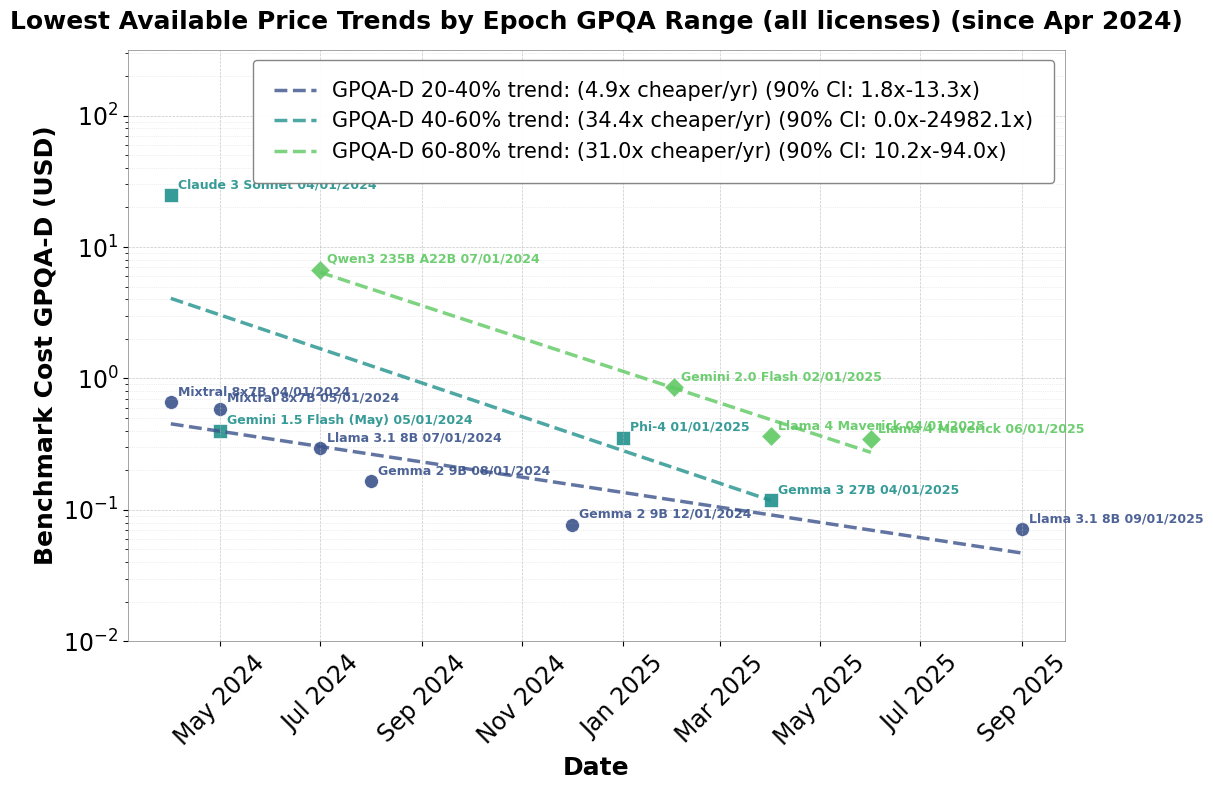

In [16]:
# --- Imports ---
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from matplotlib.dates import DateFormatter

# --- Load data ---
df = pd.read_csv('price_reduction_models.csv')
print(df.columns)

# --- Column prep ---
# Convert release date to datetime
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)

# --- Plot function with daily/monthly min fix ---
def plot_combined_record_small_trends(
    open_license_only=False,
    price_col='Lowest Blended Price AA',
    show_model_names=False,
    min_date=datetime(2023, 1, 1),
    confidence_interval=True,
    include_chinese=None,
    benchmark_col='MMLU-Pro (Reasoning & Knowledge)',
    mmlu_ranges=[(30, 50), (50, 70), (70, 90)],
    include_reasoning_models=True,
    date_granularity='day'  # 'day' (default) aggregates to daily min; use 'month' to aggregate to monthly min
):
    """
    Plot record-small points and their trend lines for specified MMLU ranges on a single graph.
    The running-min is computed AFTER collapsing to the minimum price per date (or per month).

    Parameters:
      open_license_only: If True, only include models with open licenses
      price_col: Column name for price data
      show_model_names: If True, displays model names next to record-small points
      min_date: Only include models released on or after this date (datetime or string)
      confidence_interval: If True, displays 90% confidence intervals for trend lines
      include_chinese: True => only Chinese models; False => exclude Chinese; None => all
      benchmark_col: Column name for the benchmark to use
      mmlu_ranges: List of tuples defining MMLU score ranges
      include_reasoning_models: If False, exclude reasoning models
      date_granularity: 'day' or 'month' — determines how we aggregate before cummin()
    """
    # Set up styling
    plt.rcParams['font.family'] = 'sans-serif'
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    fig.patch.set_facecolor('white'); ax.set_facecolor('white')

    palette = sns.color_palette("viridis", n_colors=len(mmlu_ranges))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']

    mmlu_col = benchmark_col
    license_col = 'License'
    chinese_col = 'Chinese'
    reasoning_col = 'Reasoning_TF'

    all_dates = []
    all_prices = []

    for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
        color = palette[i]
        marker = markers[i % len(markers)]

        # Work on a copy
        df_work = df.copy()

        # MMLU "XX%" → float
        df_work[mmlu_col] = (
            df_work[mmlu_col].astype(str)
                              .str.replace('%','',regex=False)
                              .astype(float)
        )

        # Price "$X,XXX" → float
        df_work[price_col] = (
            df_work[price_col].astype(str)
                              .str.replace('[$,]','',regex=True)
        )
        df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

        # Filter: open license
        if open_license_only:
            df_work = df_work[
                df_work[license_col].notna() &
                df_work[license_col].str.contains('open', case=False, na=False)
            ]

        # Filter: min_date
        if min_date is not None:
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            df_work = df_work[df_work['Release Date'] >= min_date]

        # Filter: Chinese
        if include_chinese is not None:
            if include_chinese:
                df_work = df_work[df_work[chinese_col] == True]
            else:
                df_work = df_work[(df_work[chinese_col] != True) | (df_work[chinese_col].isna())]

        # Filter: Reasoning models
        if not include_reasoning_models:
            df_work = df_work[(df_work[reasoning_col] != True) | (df_work[reasoning_col].isna())]

        # Filter to MMLU range
        df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

        # Drop missing Release Date / price, remove non-positive prices
        df_sub = df_sub.dropna(subset=['Release Date', price_col])
        df_sub = df_sub[df_sub[price_col] > 0]

        if len(df_sub) == 0:
            continue

        # ---- FIX: aggregate to daily/monthly minimum BEFORE running cummin ----
        df_sub = df_sub.sort_values(['Release Date', price_col]).copy()

        if date_granularity.lower().startswith('m'):
            # Monthly min: use month start timestamps for x-axis consistency
            df_sub['DateKey'] = df_sub['Release Date'].dt.to_period('M').dt.to_timestamp()
        else:
            # Daily min (default)
            df_sub['DateKey'] = df_sub['Release Date'].dt.normalize()

        # Keep the actual row that has the min price on each DateKey (so labels remain correct)
        idx_min_per_date = df_sub.groupby('DateKey')[price_col].idxmin()
        df_by_date = df_sub.loc[idx_min_per_date].sort_values('DateKey').copy()

        # Ordinal for regression
        df_by_date['Date_Ordinal'] = df_by_date['DateKey'].map(datetime.toordinal)

        # Running minima across the already-collapsed series
        df_by_date['Is_Record_Small'] = df_by_date[price_col].cummin() == df_by_date[price_col]
        record_small = df_by_date[df_by_date['Is_Record_Small']].copy()

        if len(record_small) == 0:
            continue

        # Regression on log10(price) vs ordinal date
        X_rec = record_small['Date_Ordinal'].values.reshape(-1, 1)
        y_rec_log = np.log10(record_small[price_col].values)
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)

        # R²
        r_squared = rec_ols.score(X_rec, y_rec_log)
        print(f"MMLU {min_mmlu}-{max_mmlu}% R² = {r_squared:.3f}")

        # Prediction line
        min_ord, max_ord = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
        x_range = np.arange(min_ord, max_ord + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))

        # Annual decrease rate
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365

        # 90% CI on slope (if enough points)
        n = len(X_rec)
        ci_label = ""
        if confidence_interval and n > 2:
            y_pred = rec_ols.predict(X_rec)
            residuals = y_rec_log - y_pred
            mse = np.sum(residuals**2) / (n - 2)
            se = np.sqrt(mse / np.sum((X_rec - np.mean(X_rec))**2))

            t_val = stats.t.ppf(0.95, n - 2)
            ci_lower = rec_ols.coef_[0] - t_val * se
            ci_upper = rec_ols.coef_[0] + t_val * se

            annual_factor_lower = 1 / (10**ci_upper)**365
            annual_factor_upper = 1 / (10**ci_lower)**365

            ci_label = f" (90% CI: {annual_factor_lower:.1f}x-{annual_factor_upper:.1f}x)"

        # Scatter of record-small points
        sns.scatterplot(
            x=record_small['DateKey'],
            y=record_small[price_col],
            color=color,
            s=100,
            marker=marker,
            alpha=0.9,
            edgecolor='white',
            linewidth=0.5,
            ax=ax
        )

        # Trend line
        benchmark_name = benchmark_col.split(" ")[0]
        if benchmark_name == 'epoch_gpqa':
            benchmark_name = 'GPQA-D'

        ax.plot(
            x_dates,
            10**y_rec_log_pred,
            color=color,
            linestyle='--',
            linewidth=2.5,
            alpha=0.8,
            label=f'{benchmark_name} {min_mmlu}-{max_mmlu}% trend: ({annual_factor_rec:.1f}x cheaper/yr){ci_label}'
        )

        # Confidence band
        if confidence_interval and n > 2:
            y_lower = ci_lower * x_range + rec_ols.intercept_
            y_upper = ci_upper * x_range + rec_ols.intercept_
            ax.fill_between(
                x_dates,
                10**y_lower,
                10**y_upper,
                color=color,
                alpha=0.1
            )

        # Model labels
        if show_model_names:
            for _, row in record_small.iterrows():
                ax.annotate(
                    row['Model'],
                    (row['DateKey'], row[price_col]),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=9,
                    color=color,
                    fontweight='bold',
                    alpha=0.9
                )

        all_dates.extend(record_small['DateKey'].tolist())
        all_prices.extend(record_small[price_col].tolist())

    # Axes / formatting
    ax.set_yscale('log')
    ax.set_xlabel('Date', fontsize=18, fontweight='bold')
    ax.set_ylabel('Benchmark Cost GPQA-D (USD)', fontsize=18, fontweight='bold')

    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)

    lic_label = 'open-license only' if open_license_only else 'all licenses'
    date_filter = f" (since {min_date.strftime('%b %Y')})" if min_date is not None else ""
    chinese_filter = " (Chinese models only)" if include_chinese is True else " (non-Chinese models)" if include_chinese is False else ""
    reasoning_filter = " (non-reasoning models)" if not include_reasoning_models else ""
    benchmark_name = benchmark_col.split(" ")[0]
    ax.set_title(
        f'Lowest Available Price Trends by Epoch GPQA Range ({lic_label}){date_filter}{chinese_filter}{reasoning_filter}',
        fontsize=18, fontweight='bold', pad=15
    )

    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

    legend = ax.legend(
        loc='upper right',
        fontsize=15,
        frameon=True,
        fancybox=True,
        framealpha=0.95,
        edgecolor='gray',
        borderpad=1
    )

    ax.tick_params(axis='both', which='major', labelsize=17)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)

    plt.tight_layout()
    plt.ylim(10**-2, 10**2.5)
    plt.show()


# --- Usage example (matches your last call) ---
# Daily min (default):
plot_combined_record_small_trends(
    open_license_only=False,
    price_col="Benchmark Cost USD",
    confidence_interval=True,
    min_date=datetime(2024, 4, 1),
    benchmark_col='epoch_gpqa',
    show_model_names=True,
    include_reasoning_models=True,
    mmlu_ranges=[(20, 40), (40, 60), (60, 80)],
    date_granularity='day'  # change to 'month' to aggregate monthly before cummin
)


# Model Size

In [134]:

def plot_params_small_trend_by_mmlu(
    min_mmlu,
    max_mmlu,
    df,
    open_license_only=False,
    benchmark_name='MMLU-Pro (Reasoning & Knowledge)',
    use_active_params=False,
    show_model_names=False
):
    """
    Plot number-of-parameters (in billions) vs. release date for models
    with benchmark score ∈ [min_mmlu, max_mmlu], and highlight the record-small trend
    (running minima of model size).

    Parameters:
    - min_mmlu, max_mmlu: numeric bounds on benchmark score (%)
    - df: DataFrame to use (must contain required columns)
    - open_license_only: if True, only include rows where 'License' contains 'open'
    - benchmark_name: name of the benchmark column to use (default: 'MMLU-Pro (Reasoning & Knowledge)')
    - use_active_params: if True, use 'Active Parameters' column instead of 'Parameters'
    - show_model_names: if True, display model names next to record-small points

    Assumes `df` has columns:
      - 'Release Date' (datetime64)
      - benchmark_name (e.g. '75%')
      - 'Parameters' or 'Active Parameters' (absolute count)
      - 'License' (string)
    """
    # column names
    mmlu_col    = benchmark_name
    param_col   = 'Active Parameters' if use_active_params else 'Parameters'  # choose parameter column
    license_col = 'License'             # adjust if needed

    # work on a copy
    df_work = df.copy()

    # 1) Convert benchmark score "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%', '', regex=False)
                         .astype(float)
    )

    # 2) Convert parameter counts → numeric; scale to billions
    df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')
    df_work['Params_B'] = df_work[param_col]

    # 3) Optionally filter to open-licensed models
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 4) Filter to benchmark score range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 5) Drop missing dates or sizes; remove non-positive sizes
    df_sub = df_sub.dropna(subset=['Release Date', 'Params_B'])
    df_sub = df_sub[df_sub['Params_B'] > 0]

    # 6) Sort & compute ordinal dates
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # Check if we have enough data points to proceed
    if len(df_sub) < 1:
        print(f"Warning: No data points found for the specified criteria. "
              f"MMLU range: [{min_mmlu}, {max_mmlu}], Open license only: {open_license_only}, "
              f"Using {param_col}")
        return

    # 7) Prepare X, y (log10 of Params_B)
    X     = df_sub['Date_Ordinal'].values.reshape(-1, 1)
    y_log = np.log10(df_sub['Params_B'].values)

    # 8) Fit overall OLS & median QuantileRegressor
    ols = LinearRegression().fit(X, y_log)
    qr  = QuantileRegressor(quantile=0.5, alpha=0.0).fit(X, y_log)

    # 9) Build daily grid for predictions
    lo, hi    = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range   = np.arange(lo, hi + 1)
    x_dates   = [datetime.fromordinal(int(d)) for d in x_range]
    y_ols_log = ols.predict(x_range.reshape(-1, 1))
    y_qr_log  = qr.predict(x_range.reshape(-1, 1))

    # 10) Annualized growth rates
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100

    # Calculate factor decreases (for negative percentages)
    factor_ols = 1 / (1 + annual_pct_ols/100) if annual_pct_ols < 0 else None
    factor_qr = 1 / (1 + annual_pct_qr/100) if annual_pct_qr < 0 else None

    # 11) Identify record-small points (running minima of size)
    df_sub['Is_Record_Small'] = df_sub['Params_B'].cummin() == df_sub['Params_B']
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # 12) Fit OLS on record-small points
    X_rec = record_small['Date_Ordinal'].values.reshape(-1, 1)
    y_rec_log = np.log10(record_small['Params_B'].values)

    # Only proceed with record small trend if we have at least one data point
    if len(record_small) >= 1:
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        factor_rec = 1 / (1 + annual_pct_rec/100) if annual_pct_rec < 0 else None
    else:
        rec_ols = None
        y_rec_log_pred = None
        annual_pct_rec = None
        factor_rec = None

    # 13) Plot
    plt.figure(figsize=(10, 6))

    # a) All models
    plt.scatter(
        df_sub['Release Date'], df_sub['Params_B'],
        color='gray', alpha=0.3, label='All models'
    )
    # b) Overall OLS trend
    ols_label = f'OLS trend: {annual_pct_ols:.2f}%/yr'
    if factor_ols:
        ols_label += f' ({factor_ols:.2f}× decrease/yr)'
    plt.plot(
        x_dates, 10**y_ols_log,
        'r-', lw=2, label=ols_label
    )
    # c) Median quantile trend
    qr_label = f'50th-quantile trend: {annual_pct_qr:.2f}%/yr'
    if factor_qr:
        qr_label += f' ({factor_qr:.2f}× decrease/yr)'
    plt.plot(
        x_dates, 10**y_qr_log,
        'b-.', lw=2, label=qr_label
    )

    # d & e) Only plot record small trend if we have data
    if len(record_small) >= 1:
        # d) Record-small points
        plt.scatter(
            record_small['Release Date'], record_small['Params_B'],
            color='tab:green', s=80, marker='v',
            label='Record-small points'
        )

        # Add model names if requested
        if show_model_names and 'Model' in record_small.columns:
            for i, row in record_small.iterrows():
                plt.annotate(
                    row['Model'],
                    (row['Release Date'], row['Params_B']),
                    xytext=(5, 0),
                    textcoords='offset points',
                    fontsize=8,
                    va='center'
                )

        # e) Record-small OLS trend
        if rec_ols is not None:
            rec_label = f'Record-small trend: {annual_pct_rec:.2f}%/yr'
            if factor_rec:
                rec_label += f' ({factor_rec:.2f}× decrease/yr)'
            plt.plot(
                x_dates, 10**y_rec_log_pred,
                'g--', lw=2,
                label=rec_label
            )

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Parameters (billion)')
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    param_type = 'Active Parameters' if use_active_params else 'Parameters'
    benchmark_short = benchmark_name.split(' ')[0]
    plt.title(f'Model-size Trend ({benchmark_short} ∈ [{min_mmlu},{max_mmlu}]%, {lic_label}, {param_type})')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()


Index(['Model', 'Creator', 'License', 'Context\r\n Window',
       'Artificial Analysis\r\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)',
       ...
       '5/1/2025 input price', '5/1/2025 output price', '6/1/2025 input price',
       '6/1/2025 output price', '7/1/2025 input price',
       '7/1/2025 output price', '8/1/2025 input price',
       '8/1/2025 output price', '9/1/2025 input price',
       '9/1/2025 output price'],
      dtype='object', length=108)


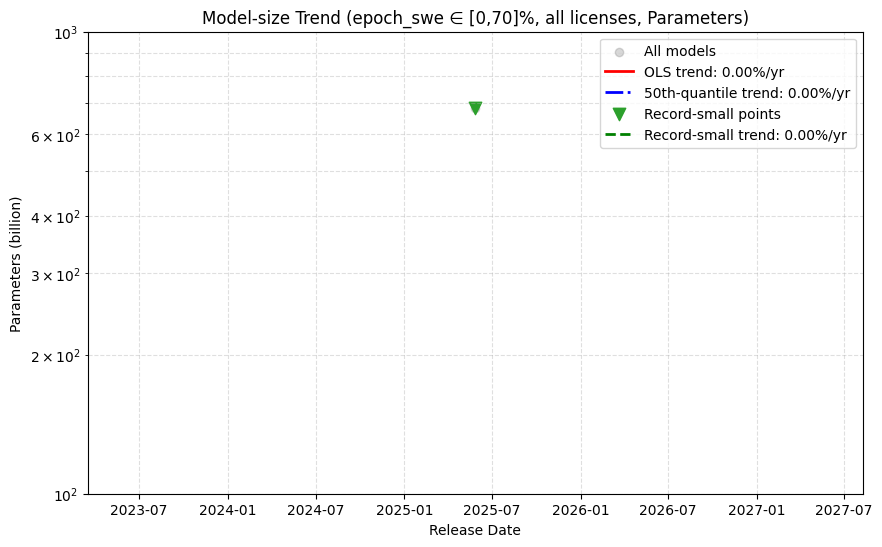

In [138]:

df = pd.read_csv('inference_data_new_large.csv')
print(df.columns)
#convert price to float
# df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)



plot_params_small_trend_by_mmlu(0, 70, df=df, open_license_only=False, use_active_params=False, benchmark_name='epoch_swe')
# plot_params_small_trend_by_mmlu(50, 70, df=df, open_license_only=True, use_active_params=False)
# plot_params_small_trend_by_mmlu(70, 90, df=df, open_license_only=True, use_active_params=False)

Index(['Model', 'Creator', 'License', 'Context\n Window',
       'Artificial Analysis\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\n USD/1M Tokens', 'Median\n Tokens/s', 'P5\n Tokens/s',
       'P25\n Tokens/s', 'P75\n Tokens/s', 'P95\n Tokens/s',
       'Median\n First Chunk (s)', 'First Answer\n Token (s)',
       'P5\n First Chunk (s)', 'P25\n First Chunk (s)',
       'P75\n First Chunk (s)', 'P95\n First Chunk (s)',
       'Total\n Response (s)', 'Reasoning\n Time (s)', 'Reasoning_TF',
       'Further\n Analysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Latency', 'token/s', 'Chinese', 'Notes',
       'Unnam

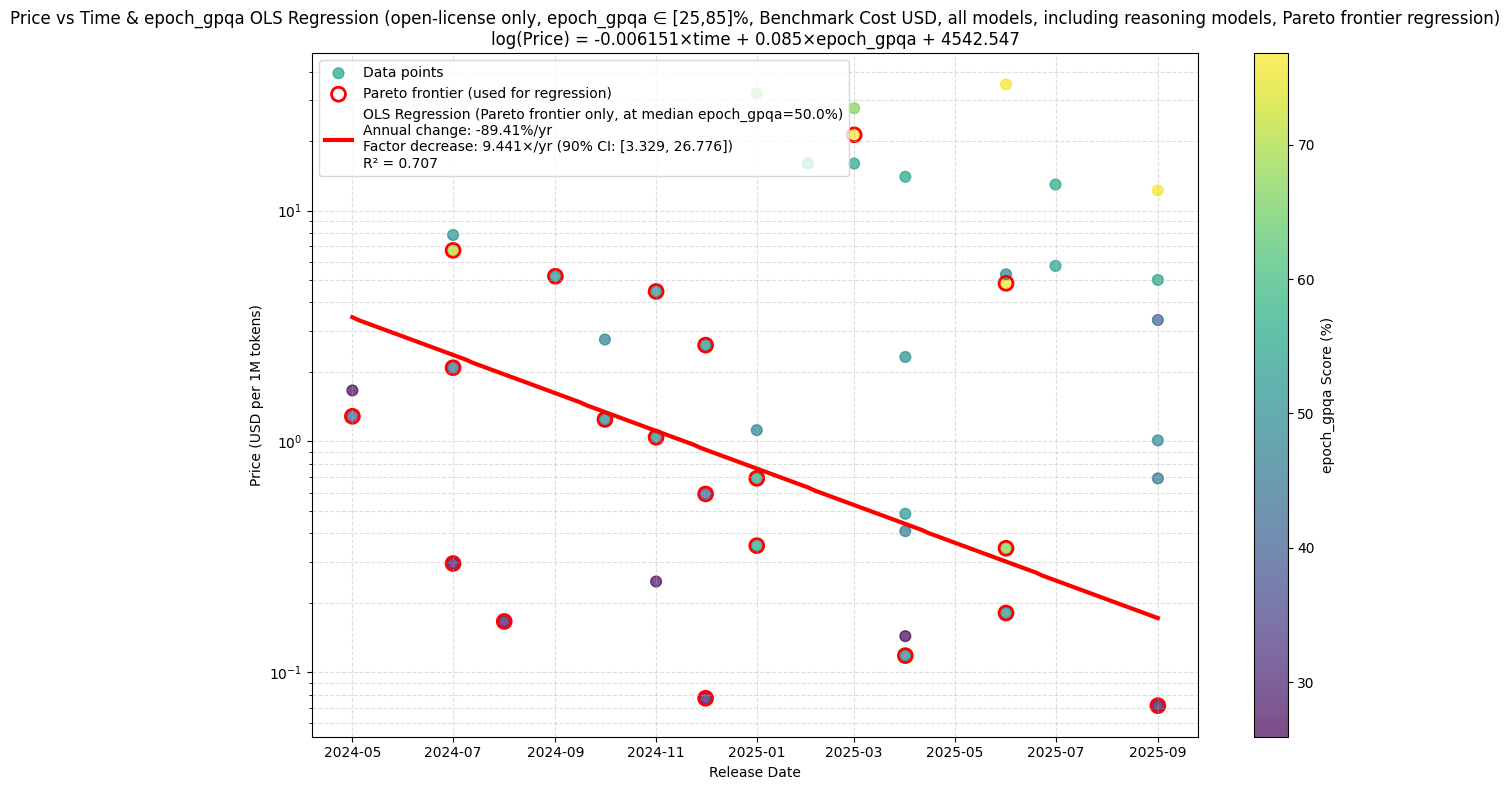


Regression Results (OLS):
Data used: Pareto frontier only
Model: log(Price) = -0.006151×time + 0.085×epoch_gpqa + 4542.547
R² score: 0.7065

Time coefficient (alpha): -0.006151
Annual percentage change: -89.41%/yr
Annual factor decrease: 9.441×/yr
90% CI for factor decrease: [3.329, 26.776]
epoch_gpqa coefficient (beta): 0.085
Intercept (c): 4542.547

Data points used for regression: 20
Data points displayed: 43


In [130]:

df = pd.read_csv('price_reduction_models.csv')
print(df.columns)
#convert price to float
# df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor
from datetime import datetime
from scipy import stats

def plot_price_mmlu_regression(
    df,
    open_license_only=False,
    min_mmlu=40,
    max_mmlu=70,
    price_column='Output Price\nUSD/1M Tokens',
    exclude_dominated=False,
    benchmark_col='MMLU-Pro (Reasoning & Knowledge)',
    exclude_reasoning=False,
    use_huber=False,
    huber_epsilon=1.35,
    huber_max_iter=100,
    pareto_frontier_only=False
):
    """
    Plot log(Price) = alpha*time + beta*GPQA + c regression

    Parameters:
    - df: DataFrame with the model data
    - open_license_only: If True, only include models with open licenses
    - min_mmlu: Minimum MMLU score to include (default: 40)
    - max_mmlu: Maximum MMLU score to include (default: 70)
    - price_column: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
    - exclude_dominated: If True, exclude models that are Pareto dominated by earlier models
    - benchmark_col: Column name for benchmark data (default: 'MMLU-Pro (Reasoning & Knowledge)')
    - exclude_reasoning: If True, exclude models with Reasoning_TF = True
    - use_huber: If True, use Huber regression instead of ordinary least squares
    - huber_epsilon: Epsilon parameter for HuberRegressor (default: 1.35)
    - huber_max_iter: Maximum iterations for HuberRegressor (default: 100)
    - pareto_frontier_only: If True, only use Pareto frontier models for the regression

    Returns fitted model coefficients and annual decrease rates
    """
    # Column names
    mmlu_col = benchmark_col
    price_col = price_column
    license_col = 'License'
    reasoning_col = 'Reasoning_TF'

    # Work on a copy
    df_work = df.copy()

    # 1) Convert MMLU "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%', '', regex=False)
                         .astype(float)
    )

    # 2) Convert price "$X,XXX" → float
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]', '', regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

    # 3) Optionally filter to open-license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 4) Optionally filter out reasoning models
    if exclude_reasoning and reasoning_col in df_work.columns:
        df_work = df_work[df_work[reasoning_col] != True]

    # 5) Filter to rows with all necessary data
    df_sub = df_work.dropna(subset=['Release Date', price_col, mmlu_col])
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[mmlu_col] > 0)]

    # 6) Filter by MMLU range
    df_sub = df_sub[(df_sub[mmlu_col] >= min_mmlu) & (df_sub[mmlu_col] <= max_mmlu)]

    # 7) Optionally filter out Pareto dominated models (this affects data display)
    df_sub_display = df_sub.copy()  # Keep original for display
    if exclude_dominated:
        df_sub_display = df_sub_display.sort_values('Release Date')
        non_dominated = []

        for i, row in df_sub_display.iterrows():
            # Check if this model is dominated by any previous model
            dominated = False
            for j in non_dominated:
                prev_row = df_sub_display.loc[j]
                # A model is dominated if there exists a previous model with:
                # 1. Better or equal MMLU score AND
                # 2. Lower or equal price
                if (prev_row[mmlu_col] >= row[mmlu_col] and 
                    prev_row[price_col] <= row[price_col] and
                    (prev_row[mmlu_col] > row[mmlu_col] or prev_row[price_col] < row[price_col])):
                    dominated = True
                    break

            if not dominated:
                non_dominated.append(i)

                # Also remove any previously added models that this one dominates
                new_non_dominated = []
                for j in non_dominated[:-1]:  # All except the one we just added
                    prev_row = df_sub_display.loc[j]
                    if not (row[mmlu_col] >= prev_row[mmlu_col] and 
                           row[price_col] <= prev_row[price_col] and
                           (row[mmlu_col] > prev_row[mmlu_col] or row[price_col] < prev_row[price_col])):
                        new_non_dominated.append(j)

                non_dominated = new_non_dominated + [i]

        df_sub_display = df_sub_display.loc[non_dominated]

    # 8) For regression, decide which data to use
    if pareto_frontier_only:
        # Identify Pareto frontier models at each point in time
        df_regression = df_sub.sort_values('Release Date').copy()
        pareto_indices = []
        
        for date in df_regression['Release Date'].unique():
            # Get all models available at this date
            available_models = df_regression[df_regression['Release Date'] <= date].copy()
            
            # Find Pareto frontier at this date
            available_models = available_models.sort_values([price_col, mmlu_col])
            frontier_indices = []
            
            for i, row in available_models.iterrows():
                # Check if this model is on the Pareto frontier
                dominated = False
                for j in frontier_indices:
                    frontier_row = available_models.loc[j]
                    # A model is dominated if there exists another model with:
                    # 1. Better or equal MMLU score AND
                    # 2. Lower or equal price
                    # AND at least one is strictly better
                    if (frontier_row[mmlu_col] >= row[mmlu_col] and 
                        frontier_row[price_col] <= row[price_col] and
                        (frontier_row[mmlu_col] > row[mmlu_col] or frontier_row[price_col] < row[price_col])):
                        dominated = True
                        break
                
                if not dominated:
                    frontier_indices.append(i)
                    # Remove any previously added models that this one dominates
                    new_frontier_indices = []
                    for j in frontier_indices[:-1]:
                        frontier_row = available_models.loc[j]
                        if not (row[mmlu_col] >= frontier_row[mmlu_col] and 
                               row[price_col] <= frontier_row[price_col] and
                               (row[mmlu_col] > frontier_row[mmlu_col] or row[price_col] < frontier_row[price_col])):
                            new_frontier_indices.append(j)
                    frontier_indices = new_frontier_indices + [i]
            
            # Add models released exactly on this date that are on the frontier
            current_date_models = df_regression[df_regression['Release Date'] == date]
            for i, row in current_date_models.iterrows():
                if i in frontier_indices:
                    pareto_indices.append(i)
        
        # Remove duplicates and use for regression
        pareto_indices = list(set(pareto_indices))
        df_regression = df_regression.loc[pareto_indices]
    else:
        df_regression = df_sub.copy()

    if len(df_regression) < 3:
        print(f"Warning: Only {len(df_regression)} data points available for regression. Need at least 3.")
        return None, None, None

    # 9) Prepare variables for regression
    df_regression = df_regression.sort_values('Release Date').copy()
    df_regression['Date_Ordinal'] = df_regression['Release Date'].map(datetime.toordinal)

    # Features: time and GPQA (not log of GPQA)
    X = np.column_stack([
        df_regression['Date_Ordinal'].values,
        df_regression[mmlu_col].values
    ])

    # Target: log(Price)
    y = np.log(df_regression[price_col].values)

    # 10) Fit regression (OLS or Huber)
    if use_huber:
        model = HuberRegressor(epsilon=huber_epsilon, max_iter=huber_max_iter).fit(X, y)
        alpha, beta = model.coef_
        c = model.intercept_
        # HuberRegressor does not provide R^2 directly, so we compute it manually
        y_pred = model.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        reg_type = "Huber"
    else:
        model = LinearRegression().fit(X, y)
        alpha, beta = model.coef_
        c = model.intercept_
        y_pred = model.predict(X)
        r2 = model.score(X, y)
        reg_type = "OLS"

    # 11) Calculate annual decrease rates
    # alpha is change in log(price) per day, so annual change is alpha * 365
    annual_log_change = alpha * 365
    annual_pct_change = (np.exp(annual_log_change) - 1) * 100
    factor_change_per_year = np.exp(annual_log_change)

    # Express as factor decrease if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_per_year = 1 / factor_change_per_year
    else:
        factor_decrease_per_year = None

    # 12) Calculate confidence intervals for the time coefficient (only for OLS)
    if not use_huber:
        n = len(df_regression)
        p = 2  # number of predictors (time and GPQA)
        residuals = y - y_pred
        mse = np.sum(residuals**2) / (n - p - 1)

        # Calculate variance-covariance matrix
        X_mean_centered = X - np.mean(X, axis=0)
        cov_matrix = np.linalg.inv(X_mean_centered.T.dot(X_mean_centered)) * mse

        # Standard error for alpha (time coefficient)
        se_alpha = np.sqrt(cov_matrix[0, 0])
        se_annual = se_alpha * 365  # Standard error for annual coefficient

        # t-statistic for 90% confidence interval
        t_stat = stats.t.ppf(0.95, n - p - 1)

        # Confidence interval for annual log change
        annual_log_change_lower = annual_log_change - t_stat * se_annual
        annual_log_change_upper = annual_log_change + t_stat * se_annual

        # Convert to factor change confidence interval
        factor_change_lower = np.exp(annual_log_change_lower)
        factor_change_upper = np.exp(annual_log_change_upper)

        # Express as factor decrease for confidence interval if price is decreasing
        if factor_change_per_year < 1:
            factor_decrease_lower = 1 / factor_change_upper
            factor_decrease_upper = 1 / factor_change_lower
        else:
            factor_decrease_lower = None
            factor_decrease_upper = None
    else:
        # HuberRegressor does not provide standard errors/confidence intervals
        factor_change_lower = None
        factor_change_upper = None
        factor_decrease_lower = None
        factor_decrease_upper = None

    # 13) Generate predictions for plotting
    min_ord, max_ord = df_regression['Date_Ordinal'].min(), df_regression['Date_Ordinal'].max()
    x_range = np.linspace(min_ord, max_ord, 100)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]

    # For visualization, we'll show the trend at median MMLU value
    median_mmlu = df_regression[mmlu_col].median()
    X_pred = np.column_stack([
        x_range,
        np.full(len(x_range), median_mmlu)
    ])
    y_pred_plot = model.predict(X_pred)

    # 14) Plot results
    plt.figure(figsize=(12, 8))

    # Color points by MMLU score for better visualization (use display data)
    scatter = plt.scatter(
        df_sub_display['Release Date'], 
        df_sub_display[price_col],
        c=df_sub_display[mmlu_col], 
        cmap='viridis', 
        alpha=0.7,
        s=60,
        label='Data points'
    )

    # If using Pareto frontier for regression, highlight those points
    if pareto_frontier_only:
        plt.scatter(
            df_regression['Release Date'], 
            df_regression[price_col],
            facecolors='none',
            edgecolors='red',
            s=100,
            linewidth=2,
            label='Pareto frontier (used for regression)'
        )

    # Add colorbar for MMLU scores
    cbar = plt.colorbar(scatter)
    benchmark_name = benchmark_col.split(' (')[0]  # Extract the main part of the benchmark name
    cbar.set_label(f'{benchmark_name} Score (%)')

    # Plot regression line (at median MMLU)
    data_source = "Pareto frontier only" if pareto_frontier_only else "all data"
    if factor_decrease_per_year:
        regression_label = (f'{reg_type} Regression ({data_source}, at median {benchmark_name}={median_mmlu:.1f}%)\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor decrease: {factor_decrease_per_year:.3f}×/yr'
                           + (f' (90% CI: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}])' if factor_decrease_lower is not None else '') +
                           f'\nR² = {r2:.3f}')
    else:
        regression_label = (f'{reg_type} Regression ({data_source}, at median {benchmark_name}={median_mmlu:.1f}%)\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor change: {factor_change_per_year:.3f}×/yr'
                           + (f' (90% CI: [{factor_change_lower:.3f}, {factor_change_upper:.3f}])' if factor_change_lower is not None else '') +
                           f'\nR² = {r2:.3f}')

    plt.plot(x_dates, np.exp(y_pred_plot), 'r-', lw=3, label=regression_label)

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Price (USD per 1M tokens)')

    lic_label = 'open-license only' if open_license_only else 'all licenses'
    mmlu_range = f"{benchmark_name} ∈ [{min_mmlu},{max_mmlu}]%"
    price_type = price_col.replace('\n', ' ')
    pareto_label = "non-dominated models only" if exclude_dominated else "all models"
    reasoning_label = "excluding reasoning models" if exclude_reasoning else "including reasoning models"
    frontier_label = "Pareto frontier regression" if pareto_frontier_only else "standard regression"
    
    plt.title(f'Price vs Time & {benchmark_name} {reg_type} Regression ({lic_label}, {mmlu_range}, {price_type}, {pareto_label}, {reasoning_label}, {frontier_label})\n'
              f'log(Price) = {alpha:.6f}×time + {beta:.3f}×{benchmark_name} + {c:.3f}')

    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # Print detailed results
    print(f"\nRegression Results ({reg_type}):")
    print(f"Data used: {data_source}")
    print(f"Model: log(Price) = {alpha:.6f}×time + {beta:.3f}×{benchmark_name} + {c:.3f}")
    print(f"R² score: {r2:.4f}")
    print(f"\nTime coefficient (alpha): {alpha:.6f}")
    print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")

    if factor_decrease_per_year:
        print(f"Annual factor decrease: {factor_decrease_per_year:.3f}×/yr")
        if factor_decrease_lower is not None:
            print(f"90% CI for factor decrease: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}]")
    else:
        print(f"Annual factor change: {factor_change_per_year:.3f}×/yr")
        if factor_change_lower is not None:
            print(f"90% CI for factor change: [{factor_change_lower:.3f}, {factor_change_upper:.3f}]")

    print(f"{benchmark_name} coefficient (beta): {beta:.3f}")
    print(f"Intercept (c): {c:.3f}")
    print(f"\nData points used for regression: {len(df_regression)}")
    print(f"Data points displayed: {len(df_sub_display)}")

    return model, df_regression, {
        'alpha': alpha,
        'beta': beta, 
        'c': c,
        'annual_pct_change': annual_pct_change,
        'factor_change_per_year': factor_change_per_year,
        'factor_decrease_per_year': factor_decrease_per_year if factor_change_per_year < 1 else None,
        'factor_change_ci_lower': factor_change_lower,
        'factor_change_ci_upper': factor_change_upper,
        'factor_decrease_ci_lower': factor_decrease_lower if factor_change_per_year < 1 else None,
        'factor_decrease_ci_upper': factor_decrease_upper if factor_change_per_year < 1 else None,
        'r2_score': r2,
        'regression_type': reg_type,
        'pareto_frontier_only': pareto_frontier_only
    }

# Index(['Model', 'Creator', 'License', 'Context\nWindow',
#        'Artificial Analysis\nIntelligence Index',
#        'MMLU-Pro (Reasoning & Knowledge)',
#        'GPQA Diamond (Scientific Reasoning)',
#        'Humanity's Last Exam (Reasoning & Knowledge)',
#        'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
#        'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
#        'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
#        'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
#        'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
#        'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
#        'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
#        'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
#        'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
#        'Further\nAnalysis', 'Release Date', 'Parameters',
#        'Known Active Parameters', 'Lowest Output Price Found AA',
#        'Lowest Input Price AA', 'Lowest Blended Price AA', 'Latency',
#        'token/s', 'Chinese', 'Notes', 'input_tokens_epoch_gpqa',
#        'outpur_tokens_epoch_gpqa', 'epoch_gpqa', 'price input lowest',
#        'price output lowest', 'total price lowest'],
#       dtype='object')


# Lowest Output Price Found AA
# Lowest Input Price AA

    # benchmark1_col="MMLU-Pro (Reasoning & Knowledge)", 
    # benchmark2_col="GPQA Diamond (Scientific Reasoning)",
    # benchmark3_col="LiveCodeBench (Coding)",

# Example usage:
# Assuming df is loaded with your data
# model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Output Price Found AA", exclude_dominated=False)
# model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Input Price AA", exclude_dominated=False)
model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Benchmark Cost USD", 
exclude_dominated=False, benchmark_col="epoch_gpqa", min_mmlu=25, max_mmlu=85, exclude_reasoning=False, use_huber=False, pareto_frontier_only=True)

Index(['Model', 'Creator', 'License', 'Context\r\n Window',
       'Artificial Analysis\r\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)',
       ...
       '5/1/2025 input price', '5/1/2025 output price', '6/1/2025 input price',
       '6/1/2025 output price', '7/1/2025 input price',
       '7/1/2025 output price', '8/1/2025 input price',
       '8/1/2025 output price', '9/1/2025 input price',
       '9/1/2025 output price'],
      dtype='object', length=108)


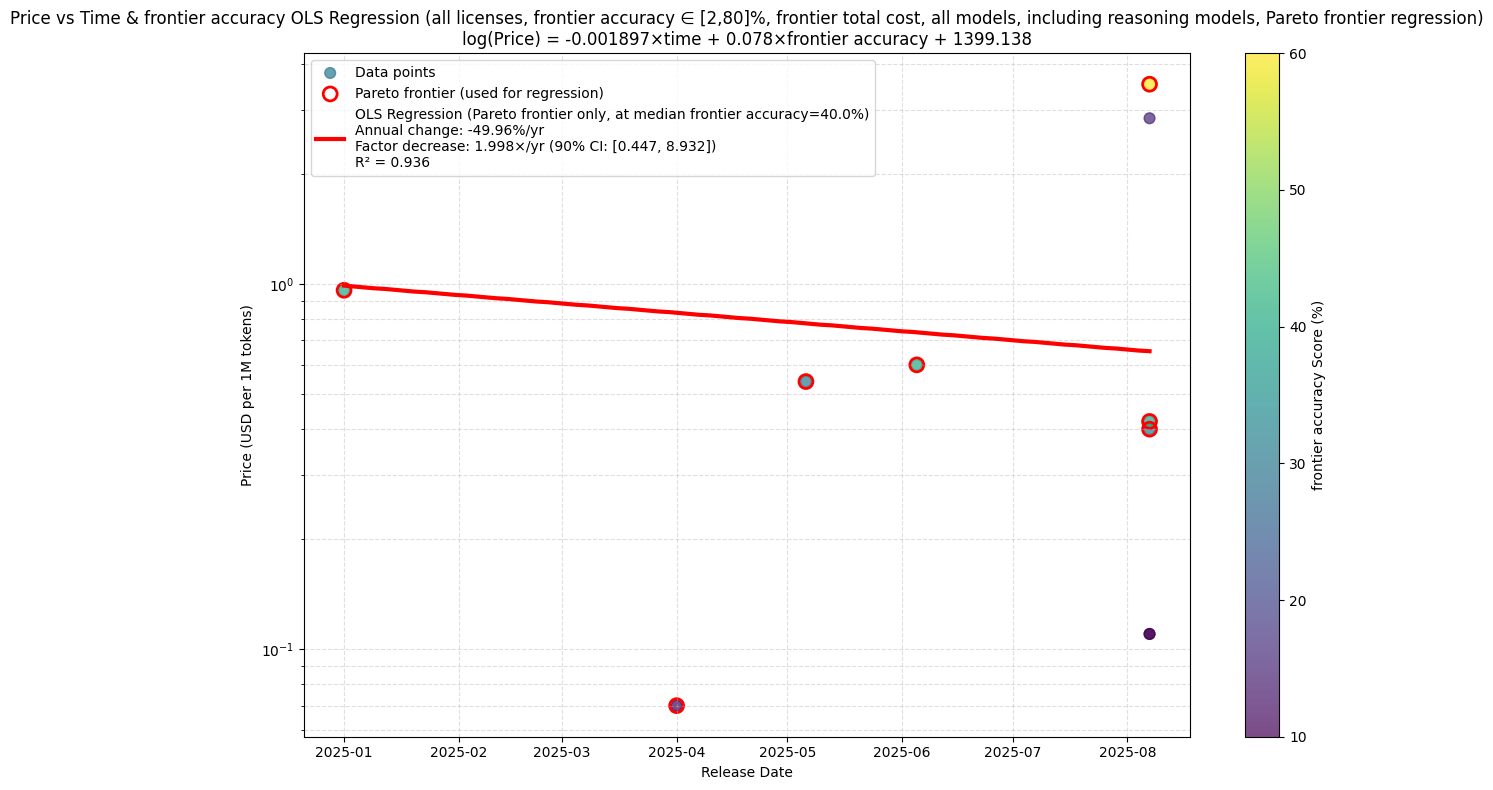


Regression Results (OLS):
Data used: Pareto frontier only
Model: log(Price) = -0.001897×time + 0.078×frontier accuracy + 1399.138
R² score: 0.9357

Time coefficient (alpha): -0.001897
Annual percentage change: -49.96%/yr
Annual factor decrease: 1.998×/yr
90% CI for factor decrease: [0.447, 8.932]
frontier accuracy coefficient (beta): 0.078
Intercept (c): 1399.138

Data points used for regression: 7
Data points displayed: 10


In [157]:
#read differnet df 

df = pd.read_csv('inference_data_new_large.csv')
print(df.columns)
#convert price to float
# df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)

model, data, results = plot_price_mmlu_regression(df, open_license_only=False, price_column="frontier total cost", 
exclude_dominated=False, benchmark_col="frontier accuracy", min_mmlu=2, max_mmlu=80, exclude_reasoning=False, use_huber=False, pareto_frontier_only=True)


# Convert Back to non-SWE

In [78]:

df = pd.read_csv('price_reduction_models.csv')
print(df.columns)
#convert price to float
# df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)

Index(['Model', 'Creator', 'License', 'Context\r\n Window',
       'Artificial Analysis\r\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\r\n USD/1M Tokens', 'Median\r\n Tokens/s', 'P5\r\n Tokens/s',
       'P25\r\n Tokens/s', 'P75\r\n Tokens/s', 'P95\r\n Tokens/s',
       'Median\r\n First Chunk (s)', 'First Answer\r\n Token (s)',
       'P5\r\n First Chunk (s)', 'P25\r\n First Chunk (s)',
       'P75\r\n First Chunk (s)', 'P95\r\n First Chunk (s)',
       'Total\r\n Response (s)', 'Reasoning\r\n Time (s)', 'Reasoning_TF',
       'Further\r\n Analysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Latency', 'token/s',

# Residualized Form Not Needed

In [151]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression, HuberRegressor
# from sklearn.preprocessing import SplineTransformer
# from datetime import datetime
# from scipy import stats

# def plot_price_mmlu_regression(
#     df,
#     open_license_only=False,
#     min_mmlu=40,
#     max_mmlu=70,
#     price_column='Output Price\nUSD/1M Tokens',
#     exclude_dominated=False,
#     benchmark_col='MMLU-Pro (Reasoning & Knowledge)',
#     exclude_reasoning=False,
#     use_huber=False,
#     huber_epsilon=1.35,
#     huber_max_iter=100,
#     pareto_frontier_only=False,
#     residualize_benchmark=False,
#     residualization_method='linear',
#     spline_n_knots=3,
#     spline_degree=3
# ):
#     """
#     Plot log(Price) = alpha*time + beta*log(MMLU Pro) + c regression

#     Parameters:
#     - df: DataFrame with the model data
#     - open_license_only: If True, only include models with open licenses
#     - min_mmlu: Minimum MMLU score to include (default: 40)
#     - max_mmlu: Maximum MMLU score to include (default: 70)
#     - price_column: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
#     - exclude_dominated: If True, exclude models that are Pareto dominated by earlier models
#     - benchmark_col: Column name for benchmark data (default: 'MMLU-Pro (Reasoning & Knowledge)')
#     - exclude_reasoning: If True, exclude models with Reasoning_TF = True
#     - use_huber: If True, use Huber regression instead of ordinary least squares
#     - huber_epsilon: Epsilon parameter for HuberRegressor (default: 1.35)
#     - huber_max_iter: Maximum iterations for HuberRegressor (default: 100)
#     - pareto_frontier_only: If True, only use Pareto frontier models for the regression
#     - residualize_benchmark: If True, residualize benchmark scores against time to handle multicollinearity
#     - residualization_method: Method for residualizing ('linear', 'spline', 'categorical') (default: 'linear')
#     - spline_n_knots: Number of knots for spline regression (default: 3)
#     - spline_degree: Degree of spline regression (default: 3)

#     Returns fitted model coefficients and annual decrease rates
#     """
#     # Column names
#     mmlu_col = benchmark_col
#     price_col = price_column
#     license_col = 'License'
#     reasoning_col = 'Reasoning_TF'

#     # Work on a copy
#     df_work = df.copy()

#     # 1) Convert MMLU "XX%" → float
#     df_work[mmlu_col] = (
#         df_work[mmlu_col].astype(str)
#                          .str.replace('%', '', regex=False)
#                          .astype(float)
#     )

#     # 2) Convert price "$X,XXX" → float
#     df_work[price_col] = (
#         df_work[price_col].astype(str)
#                          .str.replace('[$,]', '', regex=True)
#     )
#     df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

#     # 3) Optionally filter to open-license only
#     if open_license_only:
#         df_work = df_work[
#             df_work[license_col].notna() &
#             df_work[license_col].str.contains('open', case=False, na=False)
#         ]

#     # 4) Optionally filter out reasoning models
#     if exclude_reasoning and reasoning_col in df_work.columns:
#         df_work = df_work[df_work[reasoning_col] != True]

#     # 5) Filter to rows with all necessary data
#     df_sub = df_work.dropna(subset=['Release Date', price_col, mmlu_col])
#     df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[mmlu_col] > 0)]

#     # 6) Filter by MMLU range
#     df_sub = df_sub[(df_sub[mmlu_col] >= min_mmlu) & (df_sub[mmlu_col] <= max_mmlu)]

#     # 7) Optionally filter out Pareto dominated models (this affects data display)
#     df_sub_display = df_sub.copy()  # Keep original for display
#     if exclude_dominated:
#         df_sub_display = df_sub_display.sort_values('Release Date')
#         non_dominated = []

#         for i, row in df_sub_display.iterrows():
#             # Check if this model is dominated by any previous model
#             dominated = False
#             for j in non_dominated:
#                 prev_row = df_sub_display.loc[j]
#                 # A model is dominated if there exists a previous model with:
#                 # 1. Better or equal MMLU score AND
#                 # 2. Lower or equal price
#                 if (prev_row[mmlu_col] >= row[mmlu_col] and 
#                     prev_row[price_col] <= row[price_col] and
#                     (prev_row[mmlu_col] > row[mmlu_col] or prev_row[price_col] < row[price_col])):
#                     dominated = True
#                     break

#             if not dominated:
#                 non_dominated.append(i)

#                 # Also remove any previously added models that this one dominates
#                 new_non_dominated = []
#                 for j in non_dominated[:-1]:  # All except the one we just added
#                     prev_row = df_sub_display.loc[j]
#                     if not (row[mmlu_col] >= prev_row[mmlu_col] and 
#                            row[price_col] <= prev_row[price_col] and
#                            (row[mmlu_col] > prev_row[mmlu_col] or row[price_col] < prev_row[price_col])):
#                         new_non_dominated.append(j)

#                 non_dominated = new_non_dominated + [i]

#         df_sub_display = df_sub_display.loc[non_dominated]

#     # 8) For regression, decide which data to use
#     if pareto_frontier_only:
#         # Identify Pareto frontier models at each point in time
#         df_regression = df_sub.sort_values('Release Date').copy()
#         pareto_indices = []
        
#         for date in df_regression['Release Date'].unique():
#             # Get all models available at this date
#             available_models = df_regression[df_regression['Release Date'] <= date].copy()
            
#             # Find Pareto frontier at this date
#             available_models = available_models.sort_values([price_col, mmlu_col])
#             frontier_indices = []
            
#             for i, row in available_models.iterrows():
#                 # Check if this model is on the Pareto frontier
#                 dominated = False
#                 for j in frontier_indices:
#                     frontier_row = available_models.loc[j]
#                     # A model is dominated if there exists another model with:
#                     # 1. Better or equal MMLU score AND
#                     # 2. Lower or equal price
#                     # AND at least one is strictly better
#                     if (frontier_row[mmlu_col] >= row[mmlu_col] and 
#                         frontier_row[price_col] <= row[price_col] and
#                         (frontier_row[mmlu_col] > row[mmlu_col] or frontier_row[price_col] < row[price_col])):
#                         dominated = True
#                         break
                
#                 if not dominated:
#                     frontier_indices.append(i)
#                     # Remove any previously added models that this one dominates
#                     new_frontier_indices = []
#                     for j in frontier_indices[:-1]:
#                         frontier_row = available_models.loc[j]
#                         if not (row[mmlu_col] >= frontier_row[mmlu_col] and 
#                                row[price_col] <= frontier_row[price_col] and
#                                (row[mmlu_col] > frontier_row[mmlu_col] or row[price_col] < frontier_row[price_col])):
#                             new_frontier_indices.append(j)
#                     frontier_indices = new_frontier_indices + [i]
            
#             # Add models released exactly on this date that are on the frontier
#             current_date_models = df_regression[df_regression['Release Date'] == date]
#             for i, row in current_date_models.iterrows():
#                 if i in frontier_indices:
#                     pareto_indices.append(i)
        
#         # Remove duplicates and use for regression
#         pareto_indices = list(set(pareto_indices))
#         df_regression = df_regression.loc[pareto_indices]
#     else:
#         df_regression = df_sub.copy()

#     if len(df_regression) < 3:
#         print(f"Warning: Only {len(df_regression)} data points available for regression. Need at least 3.")
#         return None, None, None

#     # 9) Prepare variables for regression
#     df_regression = df_regression.sort_values('Release Date').copy()
#     df_regression['Date_Ordinal'] = df_regression['Release Date'].map(datetime.toordinal)

#     # 10) Handle multicollinearity by residualizing benchmark scores
#     benchmark_values = df_regression[mmlu_col].values
#     time_values = df_regression['Date_Ordinal'].values
    
#     if residualize_benchmark:
#         print(f"\nResidualizing benchmark scores using {residualization_method} method...")
        
#         if residualization_method == 'linear':
#             # Linear regression: benchmark ~ time
#             time_model = LinearRegression().fit(time_values.reshape(-1, 1), benchmark_values)
#             benchmark_predicted = time_model.predict(time_values.reshape(-1, 1))
#             benchmark_residuals = benchmark_values - benchmark_predicted
            
#         elif residualization_method == 'spline':
#             # Spline regression: benchmark ~ spline(time)
#             spline_transformer = SplineTransformer(n_knots=spline_n_knots, degree=spline_degree)
#             time_spline = spline_transformer.fit_transform(time_values.reshape(-1, 1))
#             time_model = LinearRegression().fit(time_spline, benchmark_values)
#             benchmark_predicted = time_model.predict(time_spline)
#             benchmark_residuals = benchmark_values - benchmark_predicted
            
#         elif residualization_method == 'categorical':
#             # Categorical time fixed effects: benchmark ~ year_dummies
#             df_temp = df_regression.copy()
#             df_temp['Year'] = df_temp['Release Date'].dt.year
            
#             # Create year dummies
#             years = df_temp['Year'].unique()
#             if len(years) > 1:  # Need at least 2 years for fixed effects
#                 year_dummies = pd.get_dummies(df_temp['Year'], drop_first=True)
#                 time_model = LinearRegression().fit(year_dummies, benchmark_values)
#                 benchmark_predicted = time_model.predict(year_dummies)
#                 benchmark_residuals = benchmark_values - benchmark_predicted
#             else:
#                 print("Warning: Only one year in data, falling back to linear residualization")
#                 time_model = LinearRegression().fit(time_values.reshape(-1, 1), benchmark_values)
#                 benchmark_predicted = time_model.predict(time_values.reshape(-1, 1))
#                 benchmark_residuals = benchmark_values - benchmark_predicted
#         else:
#             raise ValueError(f"Unknown residualization method: {residualization_method}")
        
#         # Use residuals instead of raw benchmark scores
#         log_benchmark_scores = np.log(np.abs(benchmark_residuals) + 1e-8)  # Add small constant to handle negative residuals
        
#         # Store residualization info
#         residual_r2 = 1 - np.var(benchmark_residuals) / np.var(benchmark_values)
#         print(f"Benchmark residualization R²: {residual_r2:.4f}")
#         print(f"Original benchmark std: {np.std(benchmark_values):.3f}")
#         print(f"Residual benchmark std: {np.std(benchmark_residuals):.3f}")
        
#     else:
#         log_benchmark_scores = np.log(benchmark_values)
#         residual_r2 = None

#     # Features: time and log(benchmark) or log(residualized_benchmark)
#     X = np.column_stack([
#         time_values,
#         log_benchmark_scores
#     ])

#     # Target: log(Price)
#     y = np.log(df_regression[price_col].values)

#     # 11) Fit regression (OLS or Huber)
#     if use_huber:
#         model = HuberRegressor(epsilon=huber_epsilon, max_iter=huber_max_iter).fit(X, y)
#         alpha, beta = model.coef_
#         c = model.intercept_
#         # HuberRegressor does not provide R^2 directly, so we compute it manually
#         y_pred = model.predict(X)
#         ss_res = np.sum((y - y_pred) ** 2)
#         ss_tot = np.sum((y - np.mean(y)) ** 2)
#         r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
#         reg_type = "Huber"
#     else:
#         model = LinearRegression().fit(X, y)
#         alpha, beta = model.coef_
#         c = model.intercept_
#         y_pred = model.predict(X)
#         r2 = model.score(X, y)
#         reg_type = "OLS"

#     # 12) Calculate annual decrease rates
#     # alpha is change in log(price) per day, so annual change is alpha * 365
#     annual_log_change = alpha * 365
#     annual_pct_change = (np.exp(annual_log_change) - 1) * 100
#     factor_change_per_year = np.exp(annual_log_change)

#     # Express as factor decrease if price is decreasing
#     if factor_change_per_year < 1:
#         factor_decrease_per_year = 1 / factor_change_per_year
#     else:
#         factor_decrease_per_year = None

#     # 13) Calculate confidence intervals for the time coefficient (only for OLS)
#     if not use_huber:
#         n = len(df_regression)
#         p = 2  # number of predictors (time and log(MMLU))
#         residuals = y - y_pred
#         mse = np.sum(residuals**2) / (n - p - 1)

#         # Calculate variance-covariance matrix
#         X_mean_centered = X - np.mean(X, axis=0)
#         cov_matrix = np.linalg.inv(X_mean_centered.T.dot(X_mean_centered)) * mse

#         # Standard error for alpha (time coefficient)
#         se_alpha = np.sqrt(cov_matrix[0, 0])
#         se_annual = se_alpha * 365  # Standard error for annual coefficient

#         # t-statistic for 90% confidence interval
#         t_stat = stats.t.ppf(0.95, n - p - 1)

#         # Confidence interval for annual log change
#         annual_log_change_lower = annual_log_change - t_stat * se_annual
#         annual_log_change_upper = annual_log_change + t_stat * se_annual

#         # Convert to factor change confidence interval
#         factor_change_lower = np.exp(annual_log_change_lower)
#         factor_change_upper = np.exp(annual_log_change_upper)

#         # Express as factor decrease for confidence interval if price is decreasing
#         if factor_change_per_year < 1:
#             factor_decrease_lower = 1 / factor_change_upper
#             factor_decrease_upper = 1 / factor_change_lower
#         else:
#             factor_decrease_lower = None
#             factor_decrease_upper = None
#     else:
#         # HuberRegressor does not provide standard errors/confidence intervals
#         factor_change_lower = None
#         factor_change_upper = None
#         factor_decrease_lower = None
#         factor_decrease_upper = None

#     # 14) Generate predictions for plotting
#     min_ord, max_ord = df_regression['Date_Ordinal'].min(), df_regression['Date_Ordinal'].max()
#     x_range = np.linspace(min_ord, max_ord, 100)
#     x_dates = [datetime.fromordinal(int(d)) for d in x_range]

#     # For visualization, we'll show the trend at median benchmark value
#     if residualize_benchmark:
#         median_benchmark_log = np.median(log_benchmark_scores)
#     else:
#         median_benchmark = df_regression[mmlu_col].median()
#         median_benchmark_log = np.log(median_benchmark)
    
#     X_pred = np.column_stack([
#         x_range,
#         np.full(len(x_range), median_benchmark_log)
#     ])
#     y_pred_plot = model.predict(X_pred)

#     # 15) Plot results
#     plt.figure(figsize=(12, 8))

#     # Color points by benchmark score for better visualization (use display data)
#     scatter = plt.scatter(
#         df_sub_display['Release Date'], 
#         df_sub_display[price_col],
#         c=df_sub_display[mmlu_col], 
#         cmap='viridis', 
#         alpha=0.7,
#         s=60,
#         label='Data points'
#     )

#     # If using Pareto frontier for regression, highlight those points
#     if pareto_frontier_only:
#         plt.scatter(
#             df_regression['Release Date'], 
#             df_regression[price_col],
#             facecolors='none',
#             edgecolors='red',
#             s=100,
#             linewidth=2,
#             label='Pareto frontier (used for regression)'
#         )

#     # Add colorbar for benchmark scores
#     cbar = plt.colorbar(scatter)
#     benchmark_name = benchmark_col.split(' (')[0]  # Extract the main part of the benchmark name
#     cbar.set_label(f'{benchmark_name} Score (%)')

#     # Plot regression line (at median benchmark)
#     data_source = "Pareto frontier only" if pareto_frontier_only else "all data"
#     residual_note = f" (residualized: {residualization_method})" if residualize_benchmark else ""
    
#     if residualize_benchmark:
#         median_display = "median residual"
#     else:
#         median_display = f"median {benchmark_name}={median_benchmark:.1f}%"
    
#     # Remove R² from legend label
#     if factor_decrease_per_year:
#         regression_label = (f'{reg_type} Regression ({data_source}, at {median_display}){residual_note}\n'
#                            f'Annual change: {annual_pct_change:.2f}%/yr\n'
#                            f'Factor decrease: {factor_decrease_per_year:.3f}×/yr'
#                            + (f' (90% CI: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}])' if factor_decrease_lower is not None else ''))
#     else:
#         regression_label = (f'{reg_type} Regression ({data_source}, at {median_display}){residual_note}\n'
#                            f'Annual change: {annual_pct_change:.2f}%/yr\n'
#                            f'Factor change: {factor_change_per_year:.3f}×/yr'
#                            + (f' (90% CI: [{factor_change_lower:.3f}, {factor_change_upper:.3f}])' if factor_change_lower is not None else ''))

#     plt.plot(x_dates, np.exp(y_pred_plot), 'r-', lw=3, label=regression_label)

#     plt.yscale('log')
#     plt.xlabel('Release Date')
#     plt.ylabel('Price (USD per 1M tokens)')

#     lic_label = 'open-license only' if open_license_only else 'all licenses'
#     mmlu_range = f"{benchmark_name} ∈ [{min_mmlu},{max_mmlu}]%"
#     price_type = price_col.replace('\n', ' ')
#     pareto_label = "non-dominated models only" if exclude_dominated else "all models"
#     reasoning_label = "excluding reasoning models" if exclude_reasoning else "including reasoning models"
#     frontier_label = "Pareto frontier regression" if pareto_frontier_only else "standard regression"
    
#     benchmark_var = f"residualized {benchmark_name} ({residualization_method})" if residualize_benchmark else benchmark_name
    
#     plt.title(f'Price vs Time & log({benchmark_var}) {reg_type} Regression ({lic_label}, {mmlu_range}, {price_type}, {pareto_label}, {reasoning_label}, {frontier_label})\n'
#               f'log(Price) = {alpha:.6f}×time + {beta:.3f}×log({benchmark_var}) + {c:.3f}')

#     plt.grid(True, which='both', ls='--', alpha=0.4)
#     plt.legend(loc='best')
#     plt.tight_layout()
#     plt.show()

#     # Print detailed results
#     print(f"\nRegression Results ({reg_type}):")
#     print(f"Data used: {data_source}")
#     if residualize_benchmark:
#         print(f"Benchmark residualization: {residualization_method} (R² = {residual_r2:.4f})")
#     print(f"Model: log(Price) = {alpha:.6f}×time + {beta:.3f}×log({benchmark_var}) + {c:.3f}")
#     print(f"R² score: {r2:.4f}")
#     print(f"\nTime coefficient (alpha): {alpha:.6f}")
#     print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")

#     if factor_decrease_per_year:
#         print(f"Annual factor decrease: {factor_decrease_per_year:.3f}×/yr")
#         if factor_decrease_lower is not None:
#             print(f"90% CI for factor decrease: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}]")
#     else:
#         print(f"Annual factor change: {factor_change_per_year:.3f}×/yr")
#         if factor_change_lower is not None:
#             print(f"90% CI for factor change: [{factor_change_lower:.3f}, {factor_change_upper:.3f}]")

#     print(f"log({benchmark_var}) coefficient (beta): {beta:.3f}")
#     print(f"Intercept (c): {c:.3f}")
#     print(f"\nData points used for regression: {len(df_regression)}")
#     print(f"Data points displayed: {len(df_sub_display)}")

#     return model, df_regression, {
#         'alpha': alpha,
#         'beta': beta, 
#         'c': c,
#         'annual_pct_change': annual_pct_change,
#         'factor_change_per_year': factor_change_per_year,
#         'factor_decrease_per_year': factor_decrease_per_year if factor_change_per_year < 1 else None,
#         'factor_change_ci_lower': factor_change_lower,
#         'factor_change_ci_upper': factor_change_upper,
#         'factor_decrease_ci_lower': factor_decrease_lower if factor_change_per_year < 1 else None,
#         'factor_decrease_ci_upper': factor_decrease_upper if factor_change_per_year < 1 else None,
#         'r2_score': r2,
#         'regression_type': reg_type,
#         'pareto_frontier_only': pareto_frontier_only,
#         'residualize_benchmark': residualize_benchmark,
#         'residualization_method': residualization_method if residualize_benchmark else None,
#         'residualization_r2': residual_r2
#     }

# # Index(['Model', 'Creator', 'License', 'Context\nWindow',
# #        'Artificial Analysis\nIntelligence Index',
# #        'MMLU-Pro (Reasoning & Knowledge)',
# #        'GPQA Diamond (Scientific Reasoning)',
# #        'Humanity's Last Exam (Reasoning & Knowledge)',
# #        'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
# #        'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
# #        'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
# #        'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
# #        'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
# #        'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
# #        'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
# #        'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
# #        'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
# #        'Further\nAnalysis', 'Release Date', 'Parameters',
# #        'Known Active Parameters', 'Lowest Output Price Found AA',
# #        'Lowest Input Price AA', 'Lowest Blended Price AA', 'Latency',
# #        'token/s', 'Chinese', 'Notes', 'input_tokens_epoch_gpqa',
# #        'outpur_tokens_epoch_gpqa', 'epoch_gpqa', 'price input lowest',
# #        'price output lowest', 'total price lowest'],
# #       dtype='object')


# # Lowest Output Price Found AA
# # Lowest Input Price AA

#     # benchmark1_col="MMLU-Pro (Reasoning & Knowledge)", 
#     # benchmark2_col="GPQA Diamond (Scientific Reasoning)",
#     # benchmark3_col="LiveCodeBench (Coding)",

# # Example usage:
# # Assuming df is loaded with your data
# # model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Output Price Found AA", exclude_dominated=False)
# # model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Input Price AA", exclude_dominated=False)
# # model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Benchmark Cost USD", 
# # exclude_dominated=False, benchmark_col="epoch_gpqa", min_mmlu=25, max_mmlu=80, exclude_reasoning=False, use_huber=False, pareto_frontier_only=True, residualize_benchmark=False)
# model, data, results = plot_price_mmlu_regression(df, open_license_only=False, price_column="total price swe", 
# exclude_dominated=False, benchmark_col="epoch_swe", min_mmlu=20, max_mmlu=80, exclude_reasoning=False, use_huber=False, pareto_frontier_only=False, residualize_benchmark=True)

# Graph of Total Benchmark Price vs Time

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

def plot_benchmark_price_vs_time(
    csv_file="price_reduction_models.csv",
    price_col="Benchmark Cost USD",
    benchmark_col="epoch_gpqa", 
    min_benchmark=None,
    max_benchmark=None,
    open_license_only=False,
    include_chinese=None,
    include_reasoning_models=True,
    min_date=None,
    show_model_names=False,
    confidence_interval=True,
    fit_overall_trend=True,
    exclude_dominated=False,
    use_quantile_regression=False,
    quantile=0.5,
    record_price_trend=False,
    figsize=(14, 8)
):
    """
    Graph total price for any benchmark vs release date with overall fit capability.
    
    Parameters:
    - csv_file: Path to CSV file (default: "price_reduction_models.csv")
    - price_col: Price column name (default: "Benchmark Cost USD")
    - benchmark_col: Benchmark column name (default: "epoch_gpqa")
    - min_benchmark: Minimum benchmark score to include
    - max_benchmark: Maximum benchmark score to include  
    - open_license_only: If True, only include open license models
    - include_chinese: Filter for Chinese models (True/False/None)
    - include_reasoning_models: Include reasoning models (default: True)
    - min_date: Minimum date to include (datetime or string)
    - show_model_names: Show model names on points
    - confidence_interval: Show 90% confidence intervals
    - fit_overall_trend: Fit overall trend line to all data
    - exclude_dominated: Exclude Pareto dominated models
    - use_quantile_regression: Use quantile regression instead of OLS (default: False)
    - quantile: Quantile for quantile regression (default: 0.5 for median)
    - record_price_trend: If True, fit additional trend to record (maximum) prices over time
    - figsize: Figure size tuple
    
    Returns:
    - model: Fitted regression model (record trend if record_price_trend=True, else overall trend)
    - df_filtered: Filtered dataframe used for analysis
    - stats_dict: Dictionary with regression statistics
    """
    
    # Load data
    df = pd.read_csv(csv_file)
    print(f"Loaded {len(df)} models from {csv_file}")
    
    # Work on a copy
    df_work = df.copy()
    
    # 1) Clean benchmark column
    if benchmark_col in df_work.columns:
        # Handle percentage format if present
        if df_work[benchmark_col].dtype == 'object':
            df_work[benchmark_col] = (
                df_work[benchmark_col].astype(str)
                                     .str.replace('%', '', regex=False)
                                     .str.replace('nan', '')
            )
        df_work[benchmark_col] = pd.to_numeric(df_work[benchmark_col], errors='coerce')
    else:
        print(f"Warning: Benchmark column '{benchmark_col}' not found!")
        print(f"Available columns: {list(df_work.columns)}")
        return None, None, None
    
    # 2) Clean price column
    if price_col in df_work.columns:
        if df_work[price_col].dtype == 'object':
            df_work[price_col] = (
                df_work[price_col].astype(str)
                                 .str.replace('[$,]', '', regex=True)
            )
        df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    else:
        print(f"Warning: Price column '{price_col}' not found!")
        print(f"Available columns: {list(df_work.columns)}")
        return None, None, None
    
    # 3) Handle Release Date
    if 'Release Date' in df_work.columns:
        df_work['Release Date'] = pd.to_datetime(df_work['Release Date'], errors='coerce')
    else:
        print("Warning: 'Release Date' column not found!")
        return None, None, None
    
    # 4) Apply filters
    # Filter out missing data
    df_sub = df_work.dropna(subset=['Release Date', price_col, benchmark_col])
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[benchmark_col] > 0)]
    
    # Open license filter
    if open_license_only and 'License' in df_sub.columns:
        df_sub = df_sub[
            df_sub['License'].notna() &
            df_sub['License'].str.contains('open', case=False, na=False)
        ]
    
    # Chinese models filter
    if include_chinese is not None and 'Chinese' in df_sub.columns:
        if include_chinese:
            df_sub = df_sub[df_sub['Chinese'] == True]
        else:
            df_sub = df_sub[(df_sub['Chinese'] != True) | (df_sub['Chinese'].isna())]
    
    # Reasoning models filter
    if not include_reasoning_models and 'Reasoning_TF' in df_sub.columns:
        df_sub = df_sub[(df_sub['Reasoning_TF'] != True) | (df_sub['Reasoning_TF'].isna())]
    
    # Date filter
    if min_date is not None:
        if isinstance(min_date, str):
            min_date = pd.to_datetime(min_date)
        df_sub = df_sub[df_sub['Release Date'] >= min_date]
    
    # Benchmark range filter
    if min_benchmark is not None:
        df_sub = df_sub[df_sub[benchmark_col] >= min_benchmark]
    if max_benchmark is not None:
        df_sub = df_sub[df_sub[benchmark_col] <= max_benchmark]
    
    # Exclude dominated models if requested
    if exclude_dominated:
        df_sub = df_sub.sort_values('Release Date')
        non_dominated = []
        
        for i, row in df_sub.iterrows():
            dominated = False
            for j in non_dominated:
                prev_row = df_sub.loc[j]
                # Dominated if previous model has better/equal benchmark AND lower/equal price
                if (prev_row[benchmark_col] >= row[benchmark_col] and 
                    prev_row[price_col] <= row[price_col] and
                    (prev_row[benchmark_col] > row[benchmark_col] or prev_row[price_col] < row[price_col])):
                    dominated = True
                    break
            
            if not dominated:
                non_dominated.append(i)
        
        df_sub = df_sub.loc[non_dominated]
    
    print(f"After filtering: {len(df_sub)} models")
    
    if len(df_sub) == 0:
        print("No data points remain after filtering!")
        return None, None, None
    
    # 5) Sort by date and prepare for analysis
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # 6) Fit overall trend if requested
    overall_model = None
    overall_stats = None
    if fit_overall_trend and len(df_sub) >= 3:
        # Prepare data for regression
        X = df_sub['Date_Ordinal'].values.reshape(-1, 1)
        y_log = np.log(df_sub[price_col].values)
        
        # Choose regression model based on option
        if use_quantile_regression:
            # Use quantile regression
            overall_model = QuantileRegressor(quantile=quantile, alpha=0, solver='highs').fit(X, y_log)
            # For quantile regression, we can't calculate R² in the same way
            # Instead we can compute pseudo R² based on quantile loss
            y_pred = overall_model.predict(X)
            # Calculate quantile loss for baseline (median of y) and model
            baseline_pred = np.full_like(y_log, np.quantile(y_log, quantile))
            
            def quantile_loss(y_true, y_pred, q):
                errors = y_true - y_pred
                return np.mean(np.maximum(q * errors, (q - 1) * errors))
            
            baseline_loss = quantile_loss(y_log, baseline_pred, quantile)
            model_loss = quantile_loss(y_log, y_pred, quantile)
            overall_r2 = 1 - (model_loss / baseline_loss) if baseline_loss > 0 else 0
        else:
            # Use standard linear regression
            overall_model = LinearRegression().fit(X, y_log)
            # Calculate R²
            overall_r2 = overall_model.score(X, y_log)
        
        # Calculate annual change
        overall_slope = overall_model.coef_[0] if hasattr(overall_model, 'coef_') else overall_model.coef_
        overall_annual_log_change = overall_slope * 365
        overall_annual_pct_change = (np.exp(overall_annual_log_change) - 1) * 100
        overall_factor_change_per_year = np.exp(overall_annual_log_change)
        
        # Express as factor decrease if decreasing
        if overall_factor_change_per_year < 1:
            overall_factor_decrease_per_year = 1 / overall_factor_change_per_year
        else:
            overall_factor_decrease_per_year = None
        
        # Generate prediction line
        min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
        x_range = np.arange(min_ord, max_ord + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        overall_y_pred_log = overall_model.predict(x_range.reshape(-1, 1))
        
        # Calculate confidence intervals if requested (only for OLS)
        if confidence_interval and len(df_sub) > 2 and not use_quantile_regression:
            n = len(df_sub)
            y_pred_sample = overall_model.predict(X)
            residuals = y_log - y_pred_sample
            mse = np.sum(residuals**2) / (n - 2)
            se = np.sqrt(mse / np.sum((X.flatten() - np.mean(X))**2))
            
            # t-value for 90% confidence interval
            t_val = stats.t.ppf(0.95, n - 2)
            
            # Confidence interval for slope
            ci_lower = overall_slope - t_val * se
            ci_upper = overall_slope + t_val * se
            
            # Plot confidence interval
            overall_y_lower = ci_lower * x_range + overall_model.intercept_
            overall_y_upper = ci_upper * x_range + overall_model.intercept_
            
            # CI for annual factors
            annual_factor_lower = 1 / np.exp(ci_upper * 365) if overall_factor_decrease_per_year else np.exp(ci_lower * 365)
            annual_factor_upper = 1 / np.exp(ci_lower * 365) if overall_factor_decrease_per_year else np.exp(ci_upper * 365)
            overall_ci_text = f" (90% CI: {annual_factor_lower:.1f}x-{annual_factor_upper:.1f}x)"
        else:
            overall_ci_text = ""
        
        # Store overall trend line data
        overall_trend_x_dates = x_dates
        overall_trend_y_pred = np.exp(overall_y_pred_log)
        
        if confidence_interval and len(df_sub) > 2 and not use_quantile_regression:
            overall_ci_x_dates = x_dates
            overall_ci_y_lower = np.exp(overall_y_lower)
            overall_ci_y_upper = np.exp(overall_y_upper)
        else:
            overall_ci_x_dates = None
            overall_ci_y_lower = None
            overall_ci_y_upper = None
        
        # Create overall trend label
        regression_type = f"Q{int(quantile*100)} Quantile" if use_quantile_regression else "OLS"
        # Remove R² from legend label
        if overall_factor_decrease_per_year:
            overall_trend_label = f'Overall {regression_type} Trend: {overall_factor_decrease_per_year:.1f}x cheaper/yr{overall_ci_text}'
        else:
            overall_trend_label = f'Overall {regression_type} Trend: {overall_factor_change_per_year:.1f}x/yr{overall_ci_text}'
        
        # Store overall statistics
        overall_stats = {
            'slope': overall_slope,
            'annual_pct_change': overall_annual_pct_change,
            'factor_change_per_year': overall_factor_change_per_year,
            'factor_decrease_per_year': overall_factor_decrease_per_year,
            'r2': overall_r2,
            'n_points': len(df_sub),
            'regression_type': regression_type,
            'quantile': quantile if use_quantile_regression else None,
            'trend_description': 'Overall'
        }
    
    # 7) Fit record price trend if requested
    record_model = None
    record_stats = None
    if record_price_trend and len(df_sub) >= 3:
        # Create record price trend: for each date, take the maximum price seen up to that date
        df_record = df_sub.copy()
        df_record = df_record.sort_values('Release Date')
        df_record['Cumulative_Max_Price'] = df_record[price_col].cummax()
        
        # Only keep records where the price equals the cumulative maximum (actual record setters)
        df_regression = df_record[df_record[price_col] == df_record['Cumulative_Max_Price']].copy()
        
        # Remove duplicate dates, keeping the last record for each date
        df_regression = df_regression.drop_duplicates(subset=['Release Date'], keep='last')
        
        print(f"Record price trend: Using {len(df_regression)} record-setting models")
        
        if len(df_regression) >= 3:
            # Prepare data for regression
            X_record = df_regression['Date_Ordinal'].values.reshape(-1, 1)
            y_log_record = np.log(df_regression[price_col].values)
            
            # Choose regression model based on option
            if use_quantile_regression:
                # Use quantile regression
                record_model = QuantileRegressor(quantile=quantile, alpha=0, solver='highs').fit(X_record, y_log_record)
                # For quantile regression, we can't calculate R² in the same way
                # Instead we can compute pseudo R² based on quantile loss
                y_pred_record = record_model.predict(X_record)
                # Calculate quantile loss for baseline (median of y) and model
                baseline_pred_record = np.full_like(y_log_record, np.quantile(y_log_record, quantile))
                
                def quantile_loss(y_true, y_pred, q):
                    errors = y_true - y_pred
                    return np.mean(np.maximum(q * errors, (q - 1) * errors))
                
                baseline_loss_record = quantile_loss(y_log_record, baseline_pred_record, quantile)
                model_loss_record = quantile_loss(y_log_record, y_pred_record, quantile)
                record_r2 = 1 - (model_loss_record / baseline_loss_record) if baseline_loss_record > 0 else 0
            else:
                # Use standard linear regression
                record_model = LinearRegression().fit(X_record, y_log_record)
                # Calculate R²
                record_r2 = record_model.score(X_record, y_log_record)
            
            # Calculate annual change
            record_slope = record_model.coef_[0] if hasattr(record_model, 'coef_') else record_model.coef_
            record_annual_log_change = record_slope * 365
            record_annual_pct_change = (np.exp(record_annual_log_change) - 1) * 100
            record_factor_change_per_year = np.exp(record_annual_log_change)
            
            # Express as factor decrease if decreasing
            if record_factor_change_per_year < 1:
                record_factor_decrease_per_year = 1 / record_factor_change_per_year
            else:
                record_factor_decrease_per_year = None
            
            # Generate prediction line
            record_y_pred_log = record_model.predict(x_range.reshape(-1, 1))
            
            # Store record trend line data
            record_trend_x_dates = x_dates
            record_trend_y_pred = np.exp(record_y_pred_log)
            
            # Create record trend label
            # Remove R² from legend label
            if record_factor_decrease_per_year:
                record_trend_label = f'Record Price {regression_type} Trend: {record_factor_decrease_per_year:.1f}x cheaper/yr'
            else:
                record_trend_label = f'Record Price {regression_type} Trend: {record_factor_change_per_year:.1f}x/yr'
            
            # Store record statistics
            record_stats = {
                'slope': record_slope,
                'annual_pct_change': record_annual_pct_change,
                'factor_change_per_year': record_factor_change_per_year,
                'factor_decrease_per_year': record_factor_decrease_per_year,
                'r2': record_r2,
                'n_points': len(df_regression),
                'regression_type': regression_type,
                'quantile': quantile if use_quantile_regression else None,
                'trend_description': 'Record Price'
            }
        else:
            record_trend_x_dates = None
            record_trend_y_pred = None
            record_trend_label = None
            print("Not enough record price points for trend fitting")
    else:
        df_regression = None
        record_trend_x_dates = None
        record_trend_y_pred = None
        record_trend_label = None
    
    # 8) Generate default titles and labels for customization
    benchmark_name = benchmark_col.replace('_', ' ').title()
    
    # Create title
    filter_parts = []
    if open_license_only:
        filter_parts.append("open-license only")
    if include_chinese is True:
        filter_parts.append("Chinese models")
    elif include_chinese is False:
        filter_parts.append("non-Chinese models")
    if not include_reasoning_models:
        filter_parts.append("non-reasoning models")
    if exclude_dominated:
        filter_parts.append("non-dominated only")
    
    filter_text = f" ({', '.join(filter_parts)})" if filter_parts else ""
    
    benchmark_range = ""
    if min_benchmark is not None or max_benchmark is not None:
        min_val = min_benchmark if min_benchmark is not None else "min"
        max_val = max_benchmark if max_benchmark is not None else "max"
        benchmark_range = f" | {benchmark_name}: [{min_val}, {max_val}]"
    
    # Default text values - these will be used for setting labels
    default_title_text = f'{price_col.replace("_", " ")} vs Release Date{filter_text}{benchmark_range}'
    default_xlabel_text = 'Date'
    default_ylabel_text = f'{price_col.replace("_", " ")} (USD)'
    default_colorbar_label = f'{benchmark_name} Score'
    
    ####################################################################################
    # GRAPH APPEARANCE SETTINGS - EDIT THIS SECTION TO CUSTOMIZE GRAPH LOOK
    ####################################################################################
    
    # Figure setup
    plt.figure(figsize=figsize)
    
    # Scatter plot settings
    scatter_size = 120  # Increased from 80
    scatter_alpha = 0.7
    scatter_cmap = 'viridis'
    scatter_edge_color = 'white'
    scatter_edge_width = 1.0  # Increased from 0.5
    
    # Create scatter plot
    scatter = plt.scatter(
        df_sub['Release Date'], 
        df_sub[price_col],
        c=df_sub[benchmark_col], 
        cmap=scatter_cmap, 
        alpha=scatter_alpha,
        s=scatter_size,
        edgecolors=scatter_edge_color,
        linewidth=scatter_edge_width
    )
    
    # Highlight record price points if using record price trend
    if record_price_trend and df_regression is not None:
        record_highlight_size = 180  # Increased from 120
        record_highlight_color = 'red'
        record_highlight_alpha = 0.8
        record_highlight_marker = 's'  # square marker
        
        plt.scatter(
            df_regression['Release Date'],
            df_regression[price_col],
            s=record_highlight_size,
            color=record_highlight_color,
            alpha=record_highlight_alpha,
            marker=record_highlight_marker,
            facecolors='none',
            edgecolors=record_highlight_color,
            linewidth=3,  # Increased from 2
            label='Record Price Models'
        )
    
    # Colorbar settings - CUSTOMIZABLE SECTION
    colorbar_label = default_colorbar_label  # CUSTOMIZABLE - Change this line to set custom colorbar label
    colorbar_label = "GPQA-Diamond Score"  # Custom colorbar label
    colorbar_fontsize = 22  # Increased from 16
    colorbar_tick_labelsize = 20  # Increased from 14
    colorbar_shrink = 1.0  # Controls colorbar height relative to plot
    colorbar_aspect = 20   # Controls colorbar width (higher = thinner)
    colorbar_pad = 0.02    # Distance from plot to colorbar
    
    cbar = plt.colorbar(
        scatter, 
        shrink=colorbar_shrink, 
        aspect=colorbar_aspect, 
        pad=colorbar_pad
    )
    cbar.set_label(colorbar_label, fontsize=colorbar_fontsize, fontweight='bold')
    cbar.ax.tick_params(labelsize=colorbar_tick_labelsize)
    
    # Confidence interval settings (if applicable)
    if overall_ci_x_dates is not None and overall_ci_y_lower is not None:
        ci_alpha = 0.2
        ci_color = 'blue'
        ci_label = '90% Confidence Interval (Overall)'
        
        plt.fill_between(
            overall_ci_x_dates,
            overall_ci_y_lower,
            overall_ci_y_upper,
            alpha=ci_alpha,
            color=ci_color,
            label=ci_label
        )
    
    # Overall trend line settings (if applicable)
    if overall_trend_x_dates is not None and overall_trend_y_pred is not None:
        overall_trend_color = 'blue'
        overall_trend_linewidth = 4  # Increased from 3
        overall_trend_alpha = 0.8
        
        plt.plot(
            overall_trend_x_dates, 
            overall_trend_y_pred, 
            color=overall_trend_color, 
            linewidth=overall_trend_linewidth,
            alpha=overall_trend_alpha,
            label=overall_trend_label
        )
    
    # Record trend line settings (if applicable)
    if record_trend_x_dates is not None and record_trend_y_pred is not None:
        record_trend_color = 'red'
        record_trend_linewidth = 4  # Increased from 3
        record_trend_alpha = 0.8
        record_trend_linestyle = '--'  # Dashed line to distinguish from overall trend
        
        plt.plot(
            record_trend_x_dates, 
            record_trend_y_pred, 
            color=record_trend_color, 
            linewidth=record_trend_linewidth,
            alpha=record_trend_alpha,
            linestyle=record_trend_linestyle,
            label=record_trend_label
        )
    
    # Model name annotations (if requested)
    if show_model_names and 'Model' in df_sub.columns:
        annotation_fontsize = 12  # Increased from 8
        annotation_alpha = 0.8
        annotation_offset_x = 5
        annotation_offset_y = 5
        
        for idx, row in df_sub.iterrows():
            plt.annotate(
                row['Model'], 
                (row['Release Date'], row[price_col]),
                xytext=(annotation_offset_x, annotation_offset_y), 
                textcoords='offset points',
                fontsize=annotation_fontsize,
                alpha=annotation_alpha
            )
    
    # Y-axis settings
    plt.yscale('log')
    
    # Axis labels - CUSTOMIZABLE SECTION
    xlabel_text = default_xlabel_text  # CUSTOMIZABLE - Change this line to set custom x-axis label
    xlabel_text = "Date"
    xlabel_fontsize = 26  # Increased from 20
    xlabel_fontweight = 'bold'
    
    ylabel_text = default_ylabel_text  # CUSTOMIZABLE - Change this line to set custom y-axis label
    ylabel_text = "Benchmark Price (GPQA-Diamond)"
    ylabel_fontsize = 26  # Increased from 20
    ylabel_fontweight = 'bold'
    
    plt.xlabel(xlabel_text, fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
    plt.ylabel(ylabel_text, fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
    
    # Title settings - CUSTOMIZABLE SECTION
    title_text = default_title_text  # CUSTOMIZABLE - Change this line to set custom title

    title_text = "Benchmark Price (GPQA-Diamond) vs Date"
    title_fontsize = 28  # Increased from 20
    title_fontweight = 'bold'
    title_pad = 20
    
    plt.title(title_text, fontsize=title_fontsize, fontweight=title_fontweight, pad=title_pad)
    
    # X-axis tick settings (date labels) - Set ticks every 4 months
    tick_fontsize = 22  # Increased from 15
    
    # Set x-axis ticks to show every 4 months
    from matplotlib.dates import MonthLocator, DateFormatter
    ax = plt.gca()
    ax.xaxis.set_major_locator(MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    
    plt.tick_params(axis='x', labelsize=tick_fontsize, rotation=45)
    plt.tick_params(axis='y', labelsize=tick_fontsize)
    
    # Grid settings
    major_grid_linestyle = '--'
    major_grid_linewidth = 1.0  # Increased from 0.5
    major_grid_alpha = 0.7
    
    minor_grid_linestyle = ':'
    minor_grid_linewidth = 0.8  # Increased from 0.5
    minor_grid_alpha = 0.4
    
    plt.grid(True, which='major', linestyle=major_grid_linestyle, linewidth=major_grid_linewidth, alpha=major_grid_alpha)
    plt.grid(True, which='minor', linestyle=minor_grid_linestyle, linewidth=minor_grid_linewidth, alpha=minor_grid_alpha)
    
    # Legend settings
    if fit_overall_trend or record_price_trend:
        legend_fontsize = 19  # Increased from 18
        legend_location = 'upper left'
        legend_framealpha = 0.9
        
        plt.legend(fontsize=legend_fontsize, loc=legend_location, framealpha=legend_framealpha)
    
    # Layout
    plt.tight_layout()
    ####################################################################################
    # END GRAPH APPEARANCE SETTINGS
    ####################################################################################
    
    plt.show()
    
    # 9) Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"Models analyzed: {len(df_sub)}")
    print(f"Price range: ${df_sub[price_col].min():.2f} - ${df_sub[price_col].max():.2f}")
    print(f"{benchmark_name} range: {df_sub[benchmark_col].min():.1f} - {df_sub[benchmark_col].max():.1f}")
    print(f"Date range: {df_sub['Release Date'].min().strftime('%Y-%m-%d')} to {df_sub['Release Date'].max().strftime('%Y-%m-%d')}")
    
    if overall_stats:
        print(f"\nOverall Trend Analysis ({overall_stats['regression_type']}):")
        if overall_stats['quantile']:
            print(f"Quantile: {overall_stats['quantile']}")
        print(f"Annual price change: {overall_stats['annual_pct_change']:.1f}%")
        if overall_stats['factor_decrease_per_year']:
            print(f"Price becomes {overall_stats['factor_decrease_per_year']:.1f}x cheaper each year")
        else:
            print(f"Price changes by factor of {overall_stats['factor_change_per_year']:.1f}x each year")
        metric_name = "Pseudo-R²" if use_quantile_regression else "R²"
        print(f"{metric_name} (goodness of fit): {overall_stats['r2']:.3f}")
    
    if record_stats:
        print(f"\nRecord Price Trend Analysis ({record_stats['regression_type']}):")
        print(f"Record price models used for trend: {record_stats['n_points']}")
        if record_stats['quantile']:
            print(f"Quantile: {record_stats['quantile']}")
        print(f"Annual price change: {record_stats['annual_pct_change']:.1f}%")
        if record_stats['factor_decrease_per_year']:
            print(f"Price becomes {record_stats['factor_decrease_per_year']:.1f}x cheaper each year")
        else:
            print(f"Price changes by factor of {record_stats['factor_change_per_year']:.1f}x each year")
        metric_name = "Pseudo-R²" if use_quantile_regression else "R²"
        print(f"{metric_name} (goodness of fit): {record_stats['r2']:.3f}")
    
    # Return the record model if available, otherwise the overall model
    # Combined stats dict with both trends
    combined_stats = {}
    if overall_stats:
        combined_stats['overall'] = overall_stats
    if record_stats:
        combined_stats['record'] = record_stats
    
    primary_model = record_model if record_model is not None else overall_model
    
    return primary_model, df_sub, combined_stats

# df = pd.read_csv('inference_data_new_large.csv')    

# Example usage for GPQA:
plot_benchmark_price_vs_time(
    price_col="total cost swe",
    benchmark_col="epoch_swe", 
    open_license_only=False,
    min_date="2024-01-01",
    confidence_interval=False,
    fit_overall_trend=True,
    show_model_names=False, 
    use_quantile_regression=False,
    quantile=0.9,
    record_price_trend=True
)

Loaded 65 models from price_reduction_models.csv
Available columns: ['Model', 'Creator', 'License', 'Context\n Window', 'Artificial Analysis\n Intelligence Index', 'MMLU-Pro (Reasoning & Knowledge)', 'GPQA Diamond (Scientific Reasoning)', "Humanity's Last Exam (Reasoning & Knowledge)", 'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)', 'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)', 'Multilingual Index (Artificial Analysis)', 'Chatbot Arena', 'Blended\n USD/1M Tokens', 'Median\n Tokens/s', 'P5\n Tokens/s', 'P25\n Tokens/s', 'P75\n Tokens/s', 'P95\n Tokens/s', 'Median\n First Chunk (s)', 'First Answer\n Token (s)', 'P5\n First Chunk (s)', 'P25\n First Chunk (s)', 'P75\n First Chunk (s)', 'P95\n First Chunk (s)', 'Total\n Response (s)', 'Reasoning\n Time (s)', 'Reasoning_TF', 'Further\n Analysis', 'Release Date', 'Parameters', 'Known Active Parameters', 'Latency', 'token/s', 'Chinese', 'Notes', 'Unnamed: 43', 'input_tokens_epoch_gpqa', 'output_tokens

(None, None, None)

# Pareto Frontier Graph

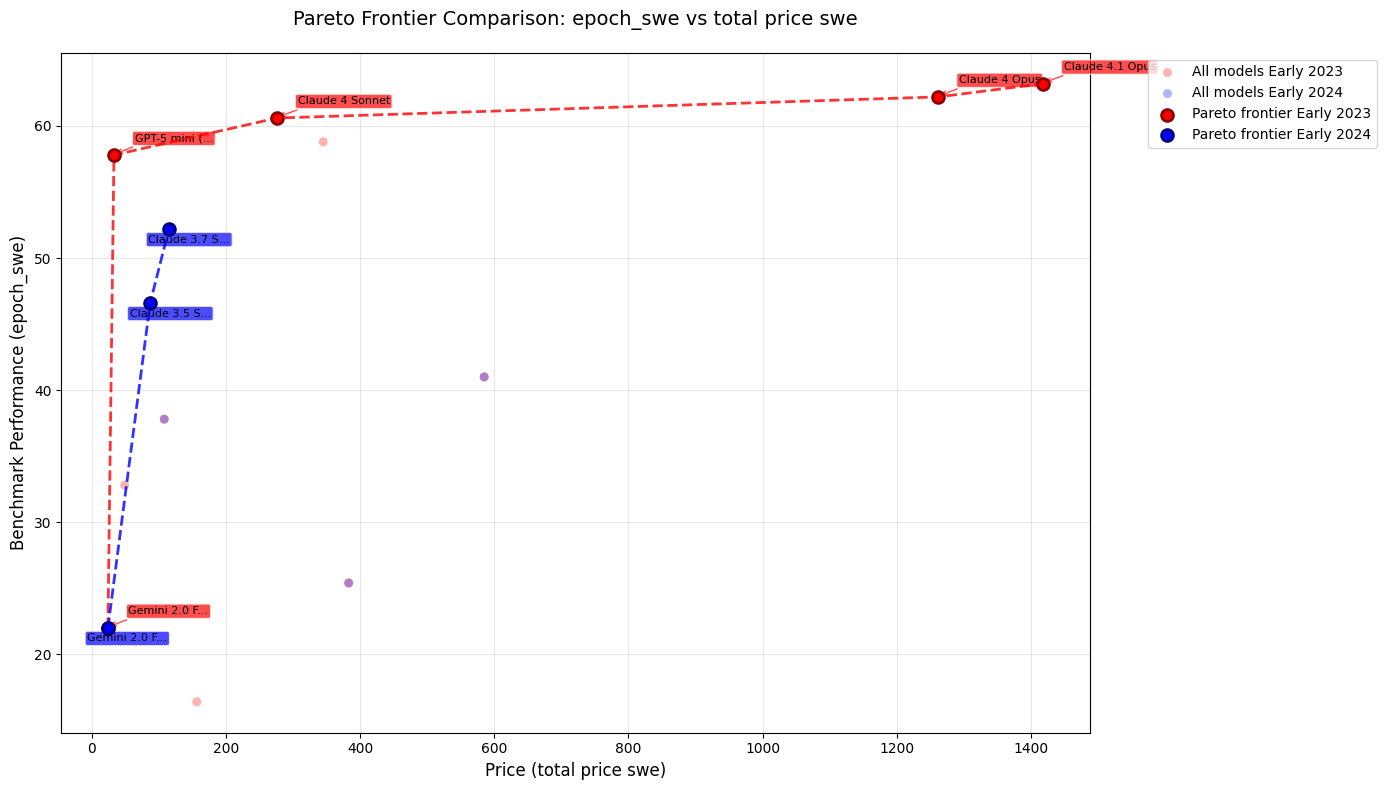


Pareto Frontier Comparison Analysis:
Period 1 (Early 2023):
  Total models: 13
  Pareto frontier models: 5

Period 2 (Early 2024):
  Total models: 6
  Pareto frontier models: 3

Pareto frontier models - Early 2023:
              Model  total price swe  epoch_swe
   Gemini 2.0 Flash             24.0       22.0
GPT-5 mini (medium)             33.0       57.8
    Claude 4 Sonnet            276.0       60.6
      Claude 4 Opus           1262.0       62.2
    Claude 4.1 Opus           1418.0       63.2

Pareto frontier models - Early 2024:
                  Model  total price swe  epoch_swe
       Gemini 2.0 Flash             24.0       22.0
Claude 3.5 Sonnet (Oct)             87.0       46.6
      Claude 3.7 Sonnet            115.0       52.2


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_pareto_frontier_comparison(
    df,
    price_column,
    benchmark_column,
    max_date1=None,
    max_date2=None,
    date1_label=None,
    date2_label=None,
    open_license_only=False,
    exclude_reasoning=False,
    min_benchmark=None,
    max_benchmark=None,
    min_price=None,
    max_price=None,
    figsize=(14, 8),
    point_size=60,
    frontier_linewidth=2,
    label_offset_x=0.02,
    label_offset_y=0.02,
    title=None,
    show_all_points=True,
    color1='red',
    color2='blue'
):
    """
    Plot Pareto frontier comparison for two different time periods.
    
    Parameters:
    - df: DataFrame with model data
    - price_column: Column name for price data
    - benchmark_column: Column name for benchmark performance data
    - max_date1: First maximum date to include (datetime or string)
    - max_date2: Second maximum date to include (datetime or string)
    - date1_label: Label for first time period (auto-generated if None)
    - date2_label: Label for second time period (auto-generated if None)
    - open_license_only: If True, only include models with open licenses
    - exclude_reasoning: If True, exclude models with Reasoning_TF = True
    - min_benchmark: Minimum benchmark score to include
    - max_benchmark: Maximum benchmark score to include
    - min_price: Minimum price to include
    - max_price: Maximum price to include
    - figsize: Figure size tuple
    - point_size: Size of scatter plot points
    - frontier_linewidth: Line width for Pareto frontier
    - label_offset_x: X offset for model labels (as fraction of x-axis range)
    - label_offset_y: Y offset for model labels (as fraction of y-axis range)
    - title: Custom title for the plot
    - show_all_points: If True, show all points; if False, only show frontier points
    - color1: Color for first time period
    - color2: Color for second time period
    
    Returns:
    - dict with pareto_models1, pareto_models2, and fig
    """
    
    def prepare_data(df, max_date, date_label):
        """Helper function to prepare data for a specific time period"""
        df_work = df.copy()
        
        # Convert price column to numeric
        if df_work[price_column].dtype == 'object':
            df_work[price_column] = (
                df_work[price_column].astype(str)
                                    .str.replace('[$,]', '', regex=True)
            )
            df_work[price_column] = pd.to_numeric(df_work[price_column], errors='coerce')
        
        # Convert benchmark column to numeric
        if df_work[benchmark_column].dtype == 'object':
            df_work[benchmark_column] = (
                df_work[benchmark_column].astype(str)
                                        .str.replace('%', '', regex=False)
            )
            df_work[benchmark_column] = pd.to_numeric(df_work[benchmark_column], errors='coerce')
        
        # Filter by date
        if max_date is not None:
            if isinstance(max_date, str):
                max_date = pd.to_datetime(max_date)
            df_work = df_work[df_work['Release Date'] <= max_date]
        
        # Apply other filters
        if open_license_only and 'License' in df_work.columns:
            df_work = df_work[
                df_work['License'].notna() &
                df_work['License'].str.contains('open', case=False, na=False)
            ]
        
        if exclude_reasoning and 'Reasoning_TF' in df_work.columns:
            df_work = df_work[df_work['Reasoning_TF'] != True]
        
        # Remove missing data
        df_work = df_work.dropna(subset=[price_column, benchmark_column])
        df_work = df_work[(df_work[price_column] > 0) & (df_work[benchmark_column] > 0)]
        
        # Apply range filters
        if min_benchmark is not None:
            df_work = df_work[df_work[benchmark_column] >= min_benchmark]
        if max_benchmark is not None:
            df_work = df_work[df_work[benchmark_column] <= max_benchmark]
        if min_price is not None:
            df_work = df_work[df_work[price_column] >= min_price]
        if max_price is not None:
            df_work = df_work[df_work[price_column] <= max_price]
        
        return df_work
    
    def find_pareto_frontier(df_data):
        """Helper function to find Pareto frontier"""
        if len(df_data) == 0:
            return df_data
            
        pareto_indices = []
        
        for i, row_i in df_data.iterrows():
            dominated = False
            for j, row_j in df_data.iterrows():
                if i != j:
                    # row_j dominates row_i if it has lower/equal price AND higher/equal benchmark
                    # with at least one being strictly better
                    if (row_j[price_column] <= row_i[price_column] and 
                        row_j[benchmark_column] >= row_i[benchmark_column] and
                        (row_j[price_column] < row_i[price_column] or row_j[benchmark_column] > row_i[benchmark_column])):
                        dominated = True
                        break
            
            if not dominated:
                pareto_indices.append(i)
        
        return df_data.loc[pareto_indices].copy()
    
    # Prepare data for both time periods
    df1 = prepare_data(df, max_date1, date1_label)
    df2 = prepare_data(df, max_date2, date2_label)
    
    if len(df1) == 0 and len(df2) == 0:
        print("No data points available after filtering for either time period.")
        return None
    
    # Find Pareto frontiers
    pareto1 = find_pareto_frontier(df1)
    pareto2 = find_pareto_frontier(df2)
    
    # Sort by price for plotting
    if len(pareto1) > 0:
        pareto1 = pareto1.sort_values(price_column)
    if len(pareto2) > 0:
        pareto2 = pareto2.sort_values(price_column)
    
    # Generate labels if not provided
    if date1_label is None:
        if max_date1 is not None:
            date1_label = f"≤ {pd.to_datetime(max_date1).strftime('%Y-%m-%d')}"
        else:
            date1_label = "All time (Period 1)"
    
    if date2_label is None:
        if max_date2 is not None:
            date2_label = f"≤ {pd.to_datetime(max_date2).strftime('%Y-%m-%d')}"
        else:
            date2_label = "All time (Period 2)"
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot all points if requested
    if show_all_points:
        if len(df1) > 0:
            ax.scatter(
                df1[price_column], 
                df1[benchmark_column],
                alpha=0.3,
                s=point_size * 0.7,
                c=color1,
                edgecolors='none',
                label=f'All models {date1_label}'
            )
        
        if len(df2) > 0:
            ax.scatter(
                df2[price_column], 
                df2[benchmark_column],
                alpha=0.3,
                s=point_size * 0.7,
                c=color2,
                edgecolors='none',
                label=f'All models {date2_label}'
            )
    
    # Plot Pareto frontier points
    if len(pareto1) > 0:
        ax.scatter(
            pareto1[price_column], 
            pareto1[benchmark_column],
            s=point_size * 1.2,
            c=color1,
            edgecolors='darkred' if color1 == 'red' else 'navy',
            linewidth=frontier_linewidth,
            label=f'Pareto frontier {date1_label}',
            zorder=5
        )
        
        # Draw frontier line
        if len(pareto1) > 1:
            ax.plot(
                pareto1[price_column], 
                pareto1[benchmark_column],
                '--',
                color=color1,
                linewidth=frontier_linewidth,
                alpha=0.8,
                zorder=4
            )
    
    if len(pareto2) > 0:
        ax.scatter(
            pareto2[price_column], 
            pareto2[benchmark_column],
            s=point_size * 1.2,
            c=color2,
            edgecolors='navy' if color2 == 'blue' else 'darkred',
            linewidth=frontier_linewidth,
            label=f'Pareto frontier {date2_label}',
            zorder=5
        )
        
        # Draw frontier line
        if len(pareto2) > 1:
            ax.plot(
                pareto2[price_column], 
                pareto2[benchmark_column],
                '--',
                color=color2,
                linewidth=frontier_linewidth,
                alpha=0.8,
                zorder=4
            )
    
    # Add labels for Pareto frontier models
    # Get axis ranges for label positioning
    x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
    y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
    
    # Label first frontier
    if len(pareto1) > 0:
        for idx, row in pareto1.iterrows():
            model_name = row['Model'] if 'Model' in row else f"Model {idx}"
            if len(model_name) > 15:
                model_name = model_name[:12] + "..."
                
            ax.annotate(
                model_name,
                (row[price_column], row[benchmark_column]),
                xytext=(
                    row[price_column] + label_offset_x * x_range,
                    row[benchmark_column] + label_offset_y * y_range
                ),
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", facecolor=color1, alpha=0.7, edgecolor='white'),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1', alpha=0.7, color=color1)
            )
    
    # Label second frontier
    if len(pareto2) > 0:
        for idx, row in pareto2.iterrows():
            model_name = row['Model'] if 'Model' in row else f"Model {idx}"
            if len(model_name) > 15:
                model_name = model_name[:12] + "..."
                
            ax.annotate(
                model_name,
                (row[price_column], row[benchmark_column]),
                xytext=(
                    row[price_column] - label_offset_x * x_range,  # Offset in opposite direction
                    row[benchmark_column] - label_offset_y * y_range
                ),
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", facecolor=color2, alpha=0.7, edgecolor='white'),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.1', alpha=0.7, color=color2)
            )
    
    # Formatting
    ax.set_xlabel(f'Price ({price_column})', fontsize=12)
    ax.set_ylabel(f'Benchmark Performance ({benchmark_column})', fontsize=12)
    
    # Create title
    if title is None:
        filters = []
        if open_license_only:
            filters.append("open license only")
        if exclude_reasoning:
            filters.append("excluding reasoning")
        
        filter_str = f" ({', '.join(filters)})" if filters else ""
        title = f'Pareto Frontier Comparison: {benchmark_column} vs {price_column}{filter_str}'
    
    ax.set_title(title, fontsize=14, pad=20)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nPareto Frontier Comparison Analysis:")
    print(f"Period 1 ({date1_label}):")
    print(f"  Total models: {len(df1)}")
    print(f"  Pareto frontier models: {len(pareto1)}")
    
    print(f"\nPeriod 2 ({date2_label}):")
    print(f"  Total models: {len(df2)}")
    print(f"  Pareto frontier models: {len(pareto2)}")
    
    if len(pareto1) > 0:
        print(f"\nPareto frontier models - {date1_label}:")
        print(pareto1[['Model', price_column, benchmark_column]].to_string(index=False))
    
    if len(pareto2) > 0:
        print(f"\nPareto frontier models - {date2_label}:")
        print(pareto2[['Model', price_column, benchmark_column]].to_string(index=False))
    
    return {
        'pareto_models1': pareto1,
        'pareto_models2': pareto2,
        'data1': df1,
        'data2': df2,
        'fig': fig
    }

# Example usage:
result = plot_pareto_frontier_comparison(
    df, 
    price_column='total price swe',
    benchmark_column='epoch_swe',
    max_date1='2026-06-01',
    max_date2='2025-03-01',
    date1_label='Early 2023',
    date2_label='Early 2024',
    open_license_only=False,
    show_all_points=True
)